# This code extracts features from nwb files

In [26]:
# import standard libraries

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import scipy
import pandas as pd 
import csv
import math

# import h5py
import h5py
# import feature extractor
import allensdk
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

# Plotting options
%matplotlib inline

# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

# change the backgroud
#plt.style.use(['seaborn-notebook'])

matplotlib.rcParams.update({'font.size': 15})
#plt.style.use(['dark_background'])

In [2]:
# Test one function to analyze all nwb files

def analyse_nwb_files(path_to_files):
    
    nwb_file_list=list()

    for file in os.listdir(path_to_files):
        if file.endswith(".nwb"):
            nwb_file_list.append(os.path.join(file))

    # create a dictionary of dictionaries
    # to store computed features
    files_features={}
    files_features_AP={}

    # dictionary of dictionaries for firing-rate
    files_features_fI={}

    # dictionaries to record spikes
    voltage_spike=[]
    time_spike=[]

    # dictionaries to record f-I curves
    firing_frequency=[]
    input_current=[]


    for l in range(0,len(nwb_file_list)):

        # load nwb as h5py
        file_name=path_to_files+str('/')+str(nwb_file_list[l])
        f = h5py.File(file_name,'r')

        # get the list of time series, access by names
        list_timeseries=f.get('acquisition/timeseries/').keys()

        print 'Analyzed file'
        print nwb_file_list[l]
        print '\n'

        print 'There are'
        print len(list_timeseries)
        print 'Sweeps'

        ### Action potential properties: Volate deap after AP (fast through-index)
        

        # Extraction of features for all sweeps
        sweep_characteristics={}

        # load the file
        f = h5py.File(file_name,'r')

        for i in range(1,len(list_timeseries)):

            # prepare the feature drict
            features_dict={}

            voltage_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/data')
            current_name=str('stimulus/presentation/Sweep_')+str(i)+str('/data')
            rate_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/starting_time')
            stim_amp_name=str('stimulus/presentation/Sweep_')+str(i)+str('/stimulus_amplitude_pa')
            stim_name=str('stimulus/presentation/Sweep_')+str(i)+str('/aibs_stimulus_name')

            # in mV
            voltage=f[voltage_name].value*1e3    
            # in pA
            current=f[current_name].value*1e12        
            # extracts the sampling rate for a given recording in Hz
            # sampling rate
            sampling_rate=f[rate_name].attrs['rate']        
            
            # substact the baseline from the input current, the average of the last 50 ms
            last_50_ms_steps=int(0.05*sampling_rate)
            current=current - np.mean(current[-last_50_ms_steps:])
            
            # time is in sec
            time = np.arange(0, len(voltage)) * (1.0 / int(sampling_rate))

            # decimate downsampling step if there are spikes
#            if max(voltage) > 0:
            voltage=scipy.signal.decimate(voltage,5)
            current=scipy.signal.decimate(current,5)                    
            time=scipy.signal.decimate(time,5)

                    # check for normal spikes
            if max(voltage) < 100:
                if min(voltage) > - 150:
                    current_amp=f[stim_amp_name].value

                    # record voltage deflection if there is a negative amplitude
                    if current_amp<0:
                        gradient_current=np.gradient(current)
                        signal_max=max(np.gradient(current))
                        signal_min=min(np.gradient(current))
                        # find the first and second indexes of the current step
                        first_ind=np.where(gradient_current == signal_max)[0][0]
                        second_ind=np.where(gradient_current == signal_min)[0][0]
                        # check for the first and second indexes
                        if first_ind>second_ind:
                            start_ind=second_ind
                            end_ind=first_ind
                        elif first_ind<second_ind:
                            start_ind=first_ind
                            end_ind=second_ind
                        # get the average voltage in the middle of the sweep
                        voltage_negative_amp=np.mean(voltage[(int(first_ind+second_ind)/2-int(0.1*sampling_rate)):(int(first_ind+second_ind)/2+int(0.1*sampling_rate))])        

                    # calculates the voltage baseline at the end of each sweep, after application of the test pulse
                    voltage_baseline=np.mean(voltage[0:int(0.1*sampling_rate)])

                    # FITTING THE TIME CONSTANT
                    # the fit is based on current step injections only!
                    if f[stim_name].value == 'Long Square':
                        if max(voltage) <= 0:
                            gradient_current=np.gradient(current)
                            signal_max=max(np.gradient(current))
                            signal_min=min(np.gradient(current))
                            # find the first and second indexes of the current step
                            first_ind=np.where(gradient_current == signal_max)[0][0]
                            second_ind=np.where(gradient_current == signal_min)[0][0]
                            # check for the first and second indexes
                            if first_ind>second_ind:
                                start_ind=second_ind
                                end_ind=first_ind
                            elif first_ind<second_ind:
                                start_ind=first_ind
                                end_ind=second_ind

                            # check for zero stimulus amplitude, if not zero, then fit
                            stim_amp = abs(np.mean(current[start_ind:end_ind]))
                            if stim_amp > 10:            
                                voltage_to_fit=voltage[int(start_ind):int(np.round((start_ind + 0.05*sampling_rate)))]
                                # a, inv_tau, y0, we need inv_tau
                                taum=allensdk.ephys.ephys_features.fit_membrane_time_constant(voltage, time, time[int(start_ind)], time[int(np.round((start_ind + 0.05*sampling_rate)))])
                                    # add time const in ms to features
                                if taum[1]:
                                    features_dict['taum']=(1/taum[1])*1000

                    # calculate the timing of the input stimuli, start and end
                    gradient_current=np.gradient(current)
                    signal_max=max(np.gradient(current))
                    signal_min=min(np.gradient(current))
                    # find the first and second indexes of the current step
                    first_ind=np.where(gradient_current == signal_max)[0][0]
                    second_ind=np.where(gradient_current == signal_min)[0][0]
                    # check for the first and second indexes
                    if first_ind>second_ind:
                        start_ind=second_ind
                        end_ind=first_ind
                    elif first_ind<second_ind:
                        start_ind=first_ind
                        end_ind=second_ind
                    #record the start/end time to the dictionary
                    features_dict['stim_start']=time[start_ind]
                    features_dict['stim_end']=time[end_ind]


                    # EXTRACTING SPIKE FEATURES
                    if f[stim_name].value == 'Long Square':
                        sweep = EphysSweepFeatureExtractor(t=time, v=voltage, i=current, start=0, end=time[-1])
                        sweep.process_spikes()

                        # RECORD FEATURES INTO THE DICTIONARY OF DICTIONARIES
                        all_spike_features=sweep.spike_feature_keys()
                        for j in range(0,len(all_spike_features)):
                            features_dict[all_spike_features[j]]=sweep.spike_feature(all_spike_features[j])
                    
                    # record the current in pA into the dictionary
                    features_dict['current_amp']=current_amp
                    # record the voltage deflection in mV into the dictionary
                    
                    if current_amp<0:
                        features_dict['voltage_negative_deflection']=voltage_negative_amp        
                    # record voltage baseline
                    features_dict['voltage_base']=voltage_baseline

                    # Record features in a dict of dict for various sweeps
                    sweep_characteristics[str('Sweep_')+str(i)]=features_dict


                    if f[stim_name].value == 'Long Square':
                        # check if there are spikes at all
                        sweep_name=str('Sweep_')+str(i)
                        if 'threshold_index' in sweep_characteristics[sweep_name]:
                            if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents                            
                                # save the sweep if there is one spike (two spike for test)
                                if len(sweep_characteristics[sweep_name]['threshold_index']) <= 2:                                
                                    # record the spike voltage and time trace per spike
                                    spike_ind_start=sweep_characteristics[sweep_name]['threshold_index'][0]-int(0.005*sampling_rate)
                                    spike_ind_end=sweep_characteristics[sweep_name]['threshold_index'][0]+int(0.005*sampling_rate)
                                    # minimal voltage - first ms after the start
                                    min_voltage=np.mean(voltage[spike_ind_start:(spike_ind_start+int(0.001*sampling_rate))])
                                    voltage_spike.append((voltage[spike_ind_start:spike_ind_end]-min_voltage))
    #                                min_time=min(time[spike_ind_start:spike_ind_end])
    #                                time_spike.append((time[spike_ind_start:spike_ind_end]-min_time)*1000)
                                    min_time=np.arange(0, len((voltage[spike_ind_start:spike_ind_end]-min_voltage))) * (1.0 / int(sampling_rate))
                                    time_spike.append(min_time*1000)



        # create the dictionary

        # store features of a file
        nwb_features={}

        ### Passive properties: membrane constant

        # Estimate the taum from single pulses

        taum_list=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:
            if 'taum' in sweep_characteristics[sweep_name]:
                taum_list.append(sweep_characteristics[sweep_name]['taum'])

        taum_list=np.array(taum_list)

        # Show taum
        print 'Initial taum estimate'
        print taum_list
        print '\n'

        # get only taum between 5 and 100 ms
        taum_list=taum_list[np.where( taum_list < 100 )]
        taum_list=taum_list[np.where( taum_list > 5 )]

        print 'Outliers removed'
        print taum_list

        # compute the values
        mean = np.mean(taum_list)
        sigma = np.std(taum_list)

        print 'The average membrane time constant in ms'
        print np.round(mean,2)

        nwb_features['taum_mean']=mean
        nwb_features['taum_sigma']=sigma

        # plot the taum as a function of sweep number

        taum_list=[]
        sweep_number=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:
                if 'taum' in sweep_characteristics[sweep_name]:
                # get only the small taum between 5 and 100 ms to remove artefacts        
                    if sweep_characteristics[sweep_name]['taum'] <100:            
                        if sweep_characteristics[sweep_name]['taum'] >5:
                            string = sweep_name
                            # just gets the first element from the one valued list
                            number=[int(s) for s in string.split('_') if s.isdigit()][0]

                            sweep_number.append(number)
                            # check for NaNs
                            if sweep_characteristics[sweep_name]['taum']:                                                        
                                taum_list.append(sweep_characteristics[sweep_name]['taum'])

        # plot the results

        ### Passive properties: average voltage

        #
        # plot the taum as a function of sweep number
        voltage_base_list=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:

                # get only the small taum between 5 and 100 ms to remove artefacts        
        #        if sweep_characteristics[sweep_name]['taum'] <100:            
        #            if sweep_characteristics[sweep_name]['taum'] >5:
                        string = sweep_name                
                        voltage_base_list.append(sweep_characteristics[sweep_name]['voltage_base'])

        # compute the values
        mean = np.mean(voltage_base_list)
        sigma = np.std(voltage_base_list)

        print 'The average membrane potential in mV'
        print np.round(mean,2)

        nwb_features['voltage_base_mean']=mean
        nwb_features['voltage_base_sigma']=sigma


        ### Passive properties: input resistance

        # Calculate and plot the input resistance for negative sweeps

        negative_current=[]
        negative_voltage=[]

        for sweep_name in sweep_characteristics:
            # pick up only the responses with the negative voltage deflections
            if bool(sweep_characteristics[sweep_name].get('voltage_negative_deflection')) == True:
                negative_current.append(sweep_characteristics[sweep_name]['current_amp'])
                negative_voltage.append(sweep_characteristics[sweep_name]['voltage_negative_deflection'] -sweep_characteristics[sweep_name]['voltage_base'])


        # create arrays to fit data
        negative_current=np.array(negative_current)/1e3  # convert to nA
        negative_voltage=np.array(negative_voltage)

        # pick up only currents in a certain range to avoid negative fitting
        pos_idx=np.where((np.array(negative_current)>-0.300) & (np.array(negative_current)<0) & (np.array(negative_voltage)< -5 ) )
        negative_current=[negative_current[i] for i in pos_idx[0]]
        negative_voltage=[negative_voltage[i] for i in pos_idx[0]]
        
        # create a linear fit for the data
        if negative_current:
            if negative_voltage:
                A = np.vstack([negative_current, np.ones(len(negative_current))]).T
                m, c = np.linalg.lstsq(A, negative_voltage)[0]
                nwb_features['R_in']=m                
        else:
            nwb_features['R_in']=np.nan
            
        print 'Input resistance in MOhm'
        print nwb_features['R_in']

        ## Active properties

        ### Active properties: f-I curve

        # Plot the f-I curve

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of input currents
        stim_input=[]
        # list of resulting frequencies
        spike_freq=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # INPUT PROCESSING
            if stimulus_type_name == 'Long Square':
                stimulus_path=str("stimulus/presentation/") +str(sweep_name) +str('/stimulus_amplitude_pa')
                stimulus_value=f[stimulus_path].value # to get the pA out of A
                # record the input current
                stim_input.append(stimulus_value)

                # SPIKES PROCESSING        
                if 'peak_t' in sweep_characteristics[sweep_name]:

                     stimulus_start_path=str("stimulus/presentation/") +str(sweep_name) +str('/starting_time')
                     all_spikes=sweep_characteristics[sweep_name]['peak_t']
                     num_spikes=len(all_spikes)
                     spike_freq.append(num_spikes/1) # all spikes during the trial

                # if there are no spikes, add 0
                else:
                    spike_freq.append(0)

        ### Active properties: f-I curve slope


        #data for the fit
        
        pos_idx=np.where((np.array(spike_freq)>0.5) & (np.array(stim_input)>0))
        
        input_value=[stim_input[i] for i in pos_idx[0]]
        feature_value=[spike_freq[i] for i in pos_idx[0]]

        #extract the theobase current and minimal frequency
        try:
            min_freq=min(feature_value)
            # get the value of the minimal element
            pos_min=np.argmin(feature_value)
            min_curr=input_value[pos_min]        
            # save the rheobase current and frequency
            nwb_features['Rheobase_current']=min_curr
            nwb_features['Rheobase_freq']=min_freq
        except (ValueError, RuntimeError, TypeError, NameError):
            nwb_features['Rheobase_current']=np.nan
            nwb_features['Rheobase_freq']=np.nan


        # REMOVE NON-UNIQUE VALUES FROM TWO LISTS!
        input_value_unique=[]
        feature_value_unique=[]    
        # convert them to arrays
        input_value_unique=np.array(input_value)
        feature_value_unique=np.array(feature_value)
        # rounding step
        input_value_unique=np.around(input_value_unique,decimals=0)

        # get only unique in input current elemnts
        input_value_unique, idx_unique = np.unique(input_value_unique, return_index=True)
        feature_value_unique=feature_value_unique[idx_unique]
        try:
            
            # correction for nA case
            if max(input_value_unique)<1:
                input_value_unique=input_value_unique*1e12

            # insert zero values until input current
            zero_steps=np.arange(0,min(input_value_unique)-1,1)
            input_value_unique=np.concatenate((zero_steps, input_value_unique), axis=0)
            zero_freq=np.zeros(len(zero_steps))
            feature_value_unique=np.concatenate((zero_freq, feature_value_unique), axis=0)

            # save the f-I curves data
            input_current.append(input_value_unique)
            firing_frequency.append(feature_value_unique)    


            #Make a linear fit
            A = np.vstack([input_value, np.ones(len(input_value))]).T

            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['fI_slope']=m
            
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['fI_slope']=np.nan
                        

        # save fI slope


        ### Active properties: relative average peak voltage

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        voltage_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike

                # check if there are spikes at all
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                voltage_value.append(sweep_characteristics[sweep_name]['peak_v'][0]-sweep_characteristics[sweep_name]['threshold_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print voltage_value
                                print input_value


        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(input_value))]).T
        try:
            m, c = np.linalg.lstsq(A, voltage_value)[0]
            nwb_features['AP_height_slope']=m
            nwb_features['AP_height_rheobase']=voltage_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_height_slope']=np.nan
            nwb_features['AP_height_rheobase']=np.nan




        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average peak voltage'
        print np.round(voltage_value,2)
        print '\n'
        print 'Average peak voltage'
        print np.round(np.mean(voltage_value),2)

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        width_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                if sweep_characteristics[sweep_name]['width'][0]:
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                    width_value.append(sweep_characteristics[sweep_name]['width'][0]*1000)
                            except (ValueError, RuntimeError, TypeError, NameError, IndexError):
                                print input_value
                                print width_value


        #Make a linear fit
        try:
            A = np.vstack([input_value, np.ones(len(width_value))]).T
            m, c = np.linalg.lstsq(A, width_value)[0]
            nwb_features['AP_width_slope']=m
            nwb_features['AP_width_rheobase']=width_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_width_slope']=np.nan
            nwb_features['AP_width_rheobase']=np.nan




        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average peak width in ms'
        print np.round(width_value,2)
        print '\n'
        print 'Average AP widtj trials in mV'
        print np.round(np.mean(width_value),2)
        print '\n'
        print 'Average threshold std in mV'
        print np.round(np.std(width_value),2)


        # export to eps
        #plt.savefig('W1_AP_width.eps', format='eps', dpi=300)



        ### Active properties: AP voltage treshold

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        thr_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                thr_value.append(sweep_characteristics[sweep_name]['threshold_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print thr_value
                                print input_value

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(thr_value))]).T
        try:
            m, c = np.linalg.lstsq(A, thr_value)[0]
            nwb_features['AP_thr_slope']=m
            nwb_features['AP_thr_rheobase']=thr_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_thr_slope']=np.nan
            nwb_features['AP_thr_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'AP threshold value in mV'
        print np.round(thr_value,2)
        print '\n'

        print 'Average start in mV'
        print np.round(np.mean(thr_value),2)
        print '\n'
        print 'Average start std in mV'
        print np.round(np.std(thr_value),2)

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                feature_value.append(sweep_characteristics[sweep_name]['fast_trough_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except (ValueError, RuntimeError, TypeError, NameError, IndexError):
                                print input_value
                                print feature_value

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_through_slope']=m
            nwb_features['AP_through_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_through_slope']=np.nan
            nwb_features['AP_through_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage trough after AP'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in mV'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in mV'
        print np.round(np.std(feature_value),2)




        ### Action potential properties: AP voltage upstroke

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            feature_value.append(sweep_characteristics[sweep_name]['upstroke_v'][0])

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_upstroke_slope']=m
            nwb_features['AP_upstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_upstroke_slope']=np.nan
            nwb_features['AP_upstroke_rheobase']=np.nan

            
        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage trough after AP in mV/ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in mV/ms'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in mV/ms'
        print np.round(np.std(feature_value),2)


        ### Action potential properties: AP voltage downstroke

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                try:
                                    feature_value.append(sweep_characteristics[sweep_name]['downstroke_v'][0])
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                except (ValueError, RuntimeError, TypeError, NameError, IndexError, KeyError):
                                    print feature_value
                                    print input_value


        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_downstroke_slope']=m
            nwb_features['AP_downstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_downstroke_slope']=np.nan
            nwb_features['AP_downstroke_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage trough after AP in mV/ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in mV/ms'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in mV/ms'
        print np.round(np.std(feature_value),2)


        ### Action potential properties: AP volage upstroke/downstroke ratio

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                try:
                                    feature_value.append(sweep_characteristics[sweep_name]['upstroke_downstroke_ratio'][0])
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                except (ValueError, RuntimeError, TypeError, NameError, IndexError, KeyError):
                                    print feature_value
                                    print input_value
                                

        #Make a linear fit
        try:
            A = np.vstack([input_value, np.ones(len(feature_value))]).T
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_up/downstroke_slope']=m
            nwb_features['AP_up/downstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_up/downstroke_slope']=np.nan
            nwb_features['AP_up/downstroke_rheobase']=np.nan

        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage upstroke/downstroke ratio'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in []'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in []'
        print np.round(np.std(feature_value),2)

        ### Active properties, spike patterns: adaptation index

        # Plot the average adaptation index as a function of the input current

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        index_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                isis=sweep_characteristics[sweep_name]['peak_t']          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                isis=allensdk.ephys.ephys_features.adaptation_index(isis) # compute the adaptation index
                                index_value.append(isis)                                  # record the index
                                
        # convert not index
        index_value=np.array(index_value)
        #get the nan index value
        nan_index=np.argwhere(np.isnan(index_value))
        # remove elements with the wrong index value
        index_value = index_value[np.isfinite(index_value)]
        # remove the corresponding element in input value if it is needed
        if len(nan_index)>0:
            input_value = [i for j, i in enumerate(input_value) if j not in nan_index]
            
        

        #Make a linear fit        
        x=np.array(input_value)
        y=np.array(index_value)

        # take only positive values
        x=x[np.where(y>0)]
        y=y[np.where(y>0)]


        #Make a linear fit
        A = np.vstack([x, np.ones(len(x))]).T
        try:
            m, c = np.linalg.lstsq(A, y)[0]
            # save the adaptation index
            nwb_features['adaptation_slope']=m
            nwb_features['adaptation_slope_rheobase']=y[np.argmin(x)]
        except (ValueError,RuntimeError, TypeError, NameError):
                nwb_features['adaptation_slope']=np.nan
                nwb_features['adaptation_slope_rheobase']=np.nan

                
        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Adaptation index value'
        print np.round(index_value,2)
        print '\n'
        print 'Average adaptation index over trials'
        print np.round(np.mean(index_value),2)


        ### Active properties, spike patterns: average interspike interval

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                if len(isis) >=1:
                                    input_value.append(np.mean(sweep_characteristics[sweep_name]['peak_i'][0]))                
                                    feature_value.append(np.mean(isis))                       # compute the average value of ISIs

        #Make an exponential fit
        x=np.array(input_value)
        y=np.array(feature_value)
        
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['mean_ISI_slope']=coeff[0]
            nwb_features['mean_ISI_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['mean_ISI_slope']=np.nan
            nwb_features['mean_ISI_slope_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average interspike interval in ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in []'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in []'
        print np.round(np.std(feature_value),2)


        ### Active properties, spike patterns: first ISI

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                if len(isis) >=1:
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])                
                                    feature_value.append(isis[0])                       # compute the average value of ISIs

        #Make an exponential fit
        x=np.array(input_value)
        y=np.array(feature_value)
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['First_ISI_slope']=coeff[0]
            nwb_features['First_ISI_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['First_ISI_slope']=np.nan
            nwb_features['First_ISI_slope_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average interspike interval in ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in []'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in []'
        print np.round(np.std(feature_value),2)


        ### Active properties, spike patterns: first spike delay

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                feature_value.append((sweep_characteristics[sweep_name]['peak_t'][0]-sweep_characteristics[sweep_name]['stim_start'])*1000)               
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print feature_value
                                print input_value
                      # compute the average value of ISIs
 

        # Make a linear fit
        x=np.array(input_value)
        y=np.array(feature_value)
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['Time_to_spike_slope']=coeff[0]    
            nwb_features['Time_to_spike_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['Time_to_spike_slope']=np.nan
            nwb_features['Time_to_spike_slope_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Time to 1st spike in ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in ms'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in ms'
        print np.round(np.std(feature_value),2)

        # add first spikes to the dictionary of dictionaries
        files_features_AP['first_spike_voltage']=voltage_spike
        files_features_AP['first_spike_time']=time_spike

        files_features_fI['input_current']=input_current
        files_features_fI['firing_frequency']=firing_frequency


        # record features into the dictionary of dictionaries
        files_features[nwb_file_list[l]]=nwb_features

        
    return files_features, files_features_AP, files_features_fI


In [3]:
# this function creates the list from files features

def matrix_from_dict(n_cells,n_features,label,files_features_dict):
    
    # +1 to add labels
    all_features_matrix=np.zeros((len(files_features_dict.keys()),n_features+1))

    # file_names list
    file_names=[]

    # counter for file names
    k=0
    
    for key in enumerate(files_features_dict.keys()):
        # save the filename
        file_names.append(key[1])
        
        # counter for features
        m=0
        
        # feature name list
        feature_names=[]
        
        for keys in enumerate(files_features_dict[key[1]]):
            # save features to the matrix
            all_features_matrix[k,0]=label
            m=m+1
            all_features_matrix[k,m]=files_features_dict[key[1]][keys[1]]
            feature_names.append(keys[1])
            
            # test code to debug the function
#            print 'key[1]'
#            print key[1]
#            print
#            print 'keys[1]'
#            print keys[1]

        k=k+1

    return all_features_matrix, file_names, feature_names

In [4]:
# lamp

files_features_H1606008, files_features_AP_H1606008, files_features_fI_H1606008 = analyse_nwb_files('./H16.06.008/nwb')


Analyzed file
16708021.nwb


There are
16
Sweeps


/Users/Anatoly/anaconda2/lib/python2.7/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in exp
  return y0 + a * np.exp(-inv_tau * x)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/allensdk/ephys/ephys_features.py:1179: RuntimeWarning: overflow encountered in multiply
  return y0 + a * np.exp(-inv_tau * x)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Initial taum estimate
[ 34.16152213  33.7650561   32.27107638  32.74666437  28.48606265
  43.21940926          nan  30.46151306  30.62660043]


Outliers removed
[ 34.16152213  33.7650561   32.27107638  32.74666437  28.48606265
  43.21940926  30.46151306  30.62660043]
The average membrane time constant in ms
33.22
The average membrane potential in mV
-58.72
Input resistance in MOhm
136.915015671
Input current in pA
[ 223.19  247.88  124.37  148.79  173.65  198.75]


Average peak voltage
[ 83.71  84.12  87.91  88.75  86.84  84.51]


Average peak voltage
85.97
Input current in pA
[ 223.19  247.88  124.37  148.79  173.65  198.75]


Average peak width in ms
[ 1.19  1.09  1.19  1.09  1.09  1.09]


Average AP widtj trials in mV
1.12


Average threshold std in mV
0.05
Input current in pA
[ 223.19  247.88  124.37  148.79  173.65  198.75]


AP threshold value in mV
[-38.44 -40.06 -37.27 -38.23 -38.56 -38.88]


Average start in mV
-38.57


Average start std in mV
0.83
Input current in pA
[ 223.19

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in less


Initial taum estimate
[ 20.86737166  23.5272754   20.60130746  26.8511867   28.93521453
  23.44950682          nan  29.54470585  65.66482001]


Outliers removed
[ 20.86737166  23.5272754   20.60130746  26.8511867   28.93521453
  23.44950682  29.54470585  65.66482001]
The average membrane time constant in ms
29.93
The average membrane potential in mV
-63.94
Input resistance in MOhm
160.547177055
Input current in pA
[ 223.11  124.27  149.02  174.18  198.69]


Average peak voltage
[ 86.01  86.    86.73  86.39  86.85]


Average peak voltage
86.4
Input current in pA
[ 223.11  124.27  149.02  174.18  198.69]


Average peak width in ms
[ 1.19  1.38  1.29  1.29  1.29]


Average AP widtj trials in mV
1.29


Average threshold std in mV
0.06
Input current in pA
[ 223.11  124.27  149.02  174.18  198.69]


AP threshold value in mV
[-35.05 -33.22 -34.32 -34.49 -34.98]


Average start in mV
-34.41


Average start std in mV
0.66
Input current in pA
[ 223.11  124.27  149.02  174.18  198.69]


Voltage t

In [5]:
# show the extracted features

files_features_H1606008

{'16708021.nwb': {'AP_downstroke_rheobase': 46.235598547716194,
  'AP_downstroke_slope': -0.1111433435191105,
  'AP_height_rheobase': 87.910989434088009,
  'AP_height_slope': -0.042085526528658421,
  'AP_thr_rheobase': -37.271909260343136,
  'AP_thr_slope': -0.017203060798630824,
  'AP_through_rheobase': -51.293612469904502,
  'AP_through_slope': 0.0095908737816544163,
  'AP_up/downstroke_rheobase': 4.1631994218954027,
  'AP_up/downstroke_slope': -0.0015951807059778127,
  'AP_upstroke_rheobase': 0.82722257734306015,
  'AP_upstroke_slope': -0.10525934788865494,
  'AP_width_rheobase': 1.1862637470660964,
  'AP_width_slope': -0.00022750633323683115,
  'First_ISI_slope': -0.021237269982895109,
  'First_ISI_slope_rheobase': 168.05402608509985,
  'R_in': 136.91501567066067,
  'Rheobase_current': 125.0,
  'Rheobase_freq': 1,
  'Time_to_spike_slope': -0.039686677874718829,
  'Time_to_spike_slope_rheobase': 841.65410481222966,
  'adaptation_slope': 0.00051353451264108568,
  'adaptation_slope_rh

In [6]:
# H1606013

files_features_H1606013, files_features_AP_H1606013, files_features_fI_H1606013 = analyse_nwb_files('./H16.06.013/nwb')


Analyzed file
1606013050101.nwb


There are
66
Sweeps
Initial taum estimate
[ 27.34890478  27.34890478  33.57843822          nan  48.32995939
  48.32995939  29.69100448  33.57843822  29.69100448          nan]


Outliers removed
[ 27.34890478  27.34890478  33.57843822  48.32995939  48.32995939
  29.69100448  33.57843822  29.69100448]
The average membrane time constant in ms
34.74
The average membrane potential in mV
-47.58
Input resistance in MOhm
43.1367662769
Input current in pA
[ 148.28  345.99  296.57  197.71  148.28   98.86  247.14  197.71  296.57
  247.14  494.28  444.85  345.99  395.42  494.28  395.42  444.85   98.86]


Average peak voltage
[ 80.51  79.15  79.63  80.29  80.51  81.06  79.59  80.29  79.63  79.59
  78.32  79.18  79.15  78.51  78.32  78.51  79.18  81.06]


Average peak voltage
79.58
Input current in pA
[ 148.28  345.99  296.57  197.71  148.28   98.86  247.14  197.71  296.57
  247.14  494.28  444.85  345.99  395.42  494.28  395.42  444.85   98.86]


Average peak width

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in less
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: invalid value encountered in less



[ 148.28  345.99  296.57  197.71  148.28   98.86  247.14  197.71  296.57
  247.14  494.28  444.85  345.99  395.42  494.28  395.42  444.85   98.86]


Voltage trough after AP in mV/ms
[ 3.    0.92  2.26 -1.76  3.   -0.48 -2.93 -1.76  2.26 -2.93 -3.42 -2.
  0.92 -1.41 -3.42 -1.41 -2.   -0.48]


Mean in mV/ms
-0.65


Std in mV/ms
2.13
Input current in pA
[ 148.28  345.99  296.57  197.71  148.28   98.86  247.14  197.71  296.57
  247.14  494.28  444.85  345.99  395.42  494.28  395.42  444.85   98.86]


Voltage trough after AP in mV/ms
[ 23.43  21.2   21.16  20.21  23.43  22.7   17.76  20.21  21.16  17.76
  17.42  18.33  21.2   18.87  17.42  18.87  18.33  22.7 ]


Mean in mV/ms
20.12


Std in mV/ms
2.04
Input current in pA
[ 148.28  345.99  296.57  197.71  148.28   98.86  247.14  197.71  296.57
  247.14  494.28  444.85  345.99  395.42  494.28  395.42  444.85   98.86]


Voltage upstroke/downstroke ratio
[ 3.82  3.49  3.45  3.61  3.82  3.88  3.58  3.61  3.45  3.58  3.41  3.55
  3.49  3.51  3.4

Input current in pA
[ 247.14  197.71  148.28  494.28  444.85  296.57  247.14  395.42  345.99
  197.71  148.28  296.57  345.99  395.42  444.85  494.28]


Adaptation index value
[ 0.03  0.05  0.29  0.02  0.02  0.02  0.03  0.02  0.03  0.05  0.29  0.02
  0.03  0.02  0.02  0.02]


Average adaptation index over trials
0.06
Input current in pA
[ 247.14  197.71  148.28  494.28  444.85  296.57  247.14  395.42  345.99
  197.71  148.28  296.57  345.99  395.42  444.85  494.28]


Average interspike interval in ms
[  46.05   73.45  156.22   25.48   26.84   37.53   46.05   30.61   34.6
   73.45  156.22   37.53   34.6    30.61   26.84   25.48]


Mean in []
53.85


Std in []
41.29
Input current in pA
[ 247.14  197.71  148.28  494.28  444.85  296.57  247.14  395.42  345.99
  197.71  148.28  296.57  345.99  395.42  444.85  494.28]


Average interspike interval in ms
[ 13.57  18.91  36.58   8.65   8.7   11.27  13.57   9.64  10.45  18.91
  36.58  11.27  10.45   9.64   8.7    8.65]


Mean in []
14.72


Std 

Analyzed file
1606013050501.nwb


There are
65
Sweeps


/Users/Anatoly/anaconda2/lib/python2.7/site-packages/allensdk/ephys/ephys_features.py:470: RuntimeWarning: invalid value encountered in less
  thresh_to_peak_levels[width_levels < v[spike_indexes]]


Initial taum estimate
[ 29.82269189  28.9230859   29.76543965  28.78495394  22.47985247
  27.45698435  29.3317799   27.52161081  31.83203683  28.14860868
  30.96929428  28.76484077]


Outliers removed
[ 29.82269189  28.9230859   29.76543965  28.78495394  22.47985247
  27.45698435  29.3317799   27.52161081  31.83203683  28.14860868
  30.96929428  28.76484077]
The average membrane time constant in ms
28.65
The average membrane potential in mV
-58.45
Input resistance in MOhm
163.752957384
Input current in pA
[ 755.58  101.31  151.52  201.76  453.43  504.03  554.09  604.33  252.34
  302.57  352.85  403.07  654.05  704.41]


Average peak voltage
[ 94.47  91.91  92.17  94.34  93.1   92.95  93.21  92.08  94.38  91.91
  92.63  93.58  90.95  93.29]


Average peak voltage
92.93
Input current in pA
[ 755.58  101.31  151.52  201.76  453.43  504.03  554.09  604.33  252.34
  302.57  352.85  403.07  654.05  704.41]


Average peak width in ms
[ 0.69  0.89  0.79  0.69  0.69  0.69  0.69  0.79  0.69  0.7

In [7]:
# show the extracted features
files_features_H1606013

{'1606013050101.nwb': {'AP_downstroke_rheobase': 22.696910834522225,
  'AP_downstroke_slope': -0.012021714906740416,
  'AP_height_rheobase': 81.055750357984692,
  'AP_height_slope': -0.0063883383527218096,
  'AP_thr_rheobase': -40.979908978155741,
  'AP_thr_slope': -0.0059575375939104665,
  'AP_through_rheobase': -53.98041879635533,
  'AP_through_slope': 0.00067468642352737438,
  'AP_up/downstroke_rheobase': 3.8846440470906636,
  'AP_up/downstroke_slope': -0.0010088805773772257,
  'AP_upstroke_rheobase': -0.48487232772472677,
  'AP_upstroke_slope': -0.0074767699955548125,
  'AP_width_rheobase': 1.210977535008706,
  'AP_width_slope': -0.00058333335042298035,
  'First_ISI_slope': -0.0050365545127558694,
  'First_ISI_slope_rheobase': 62.278844963796018,
  'R_in': 43.136766276874773,
  'Rheobase_current': 99.999508673676019,
  'Rheobase_freq': 4,
  'Time_to_spike_slope': -0.0059277108698955975,
  'Time_to_spike_slope_rheobase': 71.101681327608048,
  'adaptation_slope': -0.00055722817802624

In [8]:
# H1706012
files_features_H1706012, files_features_AP_H1706012, files_features_fI_H1706012 = analyse_nwb_files('./H17.06.012/nwb')


Analyzed file
1706012210308.nwb


There are
106
Sweeps
Initial taum estimate
[ 28.85911857  28.87508964  26.85516905  26.12761456  27.17611497
  26.22930192  28.37647485  24.15642359  26.56138972  25.41743772
  25.5293043   26.17801614  27.75271657  26.46291973  28.89713424
  23.00968927  30.39126119  30.50779152  29.67862395  30.00501244
  39.21702701  27.78344155  26.47540801  27.90302755  28.05335785
  32.8150931 ]


Outliers removed
[ 28.85911857  28.87508964  26.85516905  26.12761456  27.17611497
  26.22930192  28.37647485  24.15642359  26.56138972  25.41743772
  25.5293043   26.17801614  27.75271657  26.46291973  28.89713424
  23.00968927  30.39126119  30.50779152  29.67862395  30.00501244
  39.21702701  27.78344155  26.47540801  27.90302755  28.05335785
  32.8150931 ]
The average membrane time constant in ms
28.05
The average membrane potential in mV
-73.37
Input resistance in MOhm
87.3478301635
Input current in pA
[ 544.91  495.71  643.94  594.75  743.49  693.46  792.9   792.99

Input current in pA
[ 396.85  446.33  298.26  347.5   198.53  247.52  148.97  446.11  396.49
  347.53  298.17  496.48  595.01  545.32  496.05  594.43  544.48  594.49
  396.56  446.52  496.16  544.8   347.43  297.95  248.47  198.49  149.32
  198.34  248.04  149.19  347.37  297.58  148.98  247.83  198.93  446.26
  495.6   149.    198.58  247.98  297.36  347.18  396.77]


AP threshold value in mV
[-35.33 -34.64 -35.63 -35.03 -34.29 -33.39 -33.95 -34.42 -34.65 -34.59
 -34.28 -34.72 -37.13 -35.76 -35.32 -36.56 -35.55 -36.65 -36.04 -36.5  -36.6
 -36.48 -35.97 -36.46 -35.65 -34.58 -34.45 -34.09 -35.31 -35.75 -35.08
 -34.1  -33.64 -34.07 -33.29 -36.09 -34.09 -35.28 -33.45 -33.98 -33.81
 -33.63 -35.24]


Average start in mV
-35.01


Average start std in mV
1.03
Input current in pA
[ 396.85  446.33  298.26  347.5   198.53  247.52  148.97  446.11  396.49
  347.53  298.17  496.48  595.01  545.32  496.05  594.43  544.48  594.49
  396.56  446.52  496.16  544.8   347.43  297.95  248.47  198.49  149.3

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: invalid value encountered in less


Input current in pA
[ 497.2   449.2   204.98  148.9   100.17  398.69  346.11  297.7   251.22
  746.6   650.64  699.92  544.56  602.84  449.68  501.43  202.93  149.44
  306.    248.42  398.88  347.43  444.38  505.33  549.82  606.24  249.54
  306.71  350.29  400.72  650.62  694.2   104.56  150.    196.9   743.62
  546.8   603.67  654.93  701.39  743.4 ]


AP threshold value in mV
[-49.75 -49.12 -46.73 -42.17 -42.32 -50.96 -47.62 -47.19 -45.58 -51.41
 -51.09 -51.68 -52.09 -50.25 -50.61 -49.28 -45.53 -43.5  -46.69 -47.23
 -48.78 -48.61 -47.58 -47.92 -49.87 -51.22 -45.26 -45.22 -46.46 -46.97
 -52.7  -52.98 -42.75 -43.8  -43.2  -56.22 -52.95 -52.78 -52.44 -54.66
 -55.56]


Average start in mV
-48.75


Average start std in mV
3.64
Input current in pA
[ 497.2   449.2   204.98  148.9   100.17  398.69  346.11  297.7   251.22
  746.6   650.64  699.92  544.56  602.84  449.68  501.43  202.93  149.44
  306.    248.42  398.88  347.43  444.38  505.33  549.82  606.24  249.54
  306.71  350.29  400.72  6

Input current in pA
[  3.48930000e+02   4.50200000e+01   1.00750000e+02   5.21700000e+01
   2.50600000e+02   1.97470000e+02   3.47780000e+02   3.03400000e+02
   4.28000000e+01   1.01160000e+02   1.49590000e+02   1.97310000e+02
   4.02070000e+02   3.98920000e+02   1.00070000e+02   4.94220000e+02
   3.30000000e-01   3.00690000e+02   3.50540000e+02   4.04690000e+02
   1.54060000e+02   1.92430000e+02   2.46370000e+02   2.99660000e+02]


Voltage trough after AP
[-51.84 -63.38 -60.27 -62.54 -55.85 -57.73 -53.77 -54.54 -57.87 -54.11
 -50.04 -46.48 -52.55 -50.44 -61.44 -27.75 -60.04 -38.27 -34.12 -31.34
 -58.29 -55.91 -54.6  -52.89]


Mean in mV
-51.92


Std in mV
9.53
Input current in pA
[  3.48930000e+02   4.50200000e+01   1.00750000e+02   5.21700000e+01
   2.50600000e+02   1.97470000e+02   3.47780000e+02   3.03400000e+02
   4.28000000e+01   1.01160000e+02   1.49590000e+02   1.97310000e+02
   4.02070000e+02   3.98920000e+02   1.00070000e+02   4.94220000e+02
   3.30000000e-01   3.00690000e+02

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1058: RuntimeWarning: invalid value encountered in log
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1058: RuntimeWarning: invalid value encountered in sqrt
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1058: RankWarning: Polyfit may be poorly conditioned



1706012210403.nwb


There are
88
Sweeps
Initial taum estimate
[ 32.15092862  22.11549809  18.10902849  33.42330307  27.47393113
  25.75161958  23.93968891  28.07988383  19.15513369  38.19387544
  28.83746448  33.62767218  28.81014851  25.05028196  31.31474223
  22.99751518  17.48836426]


Outliers removed
[ 32.15092862  22.11549809  18.10902849  33.42330307  27.47393113
  25.75161958  23.93968891  28.07988383  19.15513369  38.19387544
  28.83746448  33.62767218  28.81014851  25.05028196  31.31474223
  22.99751518  17.48836426]
The average membrane time constant in ms
26.85
The average membrane potential in mV
-64.33
Input resistance in MOhm
130.595923876
Input current in pA
[ 157.04  747.91  694.99  449.57  498.68  551.83  603.3   249.95  300.46
  350.04  399.73  655.6   706.45  101.52  150.75  199.02  598.76  649.11
  302.16  349.83  196.39  249.16  497.03  551.52  396.48  448.02  150.18
  743.92  202.84  256.12  298.9   346.29  398.07  446.85  502.55  551.78]


Average peak voltage


Input current in pA
[ 346.4   547.84  596.76  547.1   598.64  403.92  342.97  506.86  445.44
  199.57  148.57  301.37  249.19  695.05  647.9   398.39  747.15  798.96
  149.26  199.41  252.17  300.8   450.53  497.57]


Voltage trough after AP
[-49.79 -49.64 -50.03 -50.35 -49.32 -50.17 -50.06 -50.15 -50.3  -50.51
 -50.15 -50.05 -49.77 -49.12 -49.01 -49.6  -48.82 -48.61 -49.42 -50.38
 -50.32 -49.74 -49.51 -49.57]


Mean in mV
-49.77


Std in mV
0.51
Input current in pA
[ 346.4   547.84  596.76  547.1   598.64  403.92  342.97  506.86  445.44
  199.57  148.57  301.37  249.19  695.05  647.9   398.39  747.15  798.96
  149.26  199.41  252.17  300.8   450.53  497.57]


Voltage trough after AP in mV/ms
[-39.33 -25.44 -44.23 -44.03 -26.62 -14.51  -1.22 -38.31 -21.22 -38.61
   4.23 -16.95 -22.64 -24.42 -37.3  -41.6   -0.1  -43.19 -36.36 -28.98
 -21.44 -11.53 -32.49  -0.8 ]


Mean in mV/ms
-25.29


Std in mV/ms
14.82
Input current in pA
[ 346.4   547.84  596.76  547.1   598.64  403.92  342.97  506.

Input current in pA
[ 251.76  192.85  151.6   401.97  358.66  296.25  153.48  202.63  250.41
  305.16  350.99]


Voltage upstroke/downstroke ratio
[ 2.65  2.62  2.68  2.78  2.64  3.06  2.68  2.51  2.68  2.83  2.62]


Mean in []
2.7


Std in []
0.14
Input current in pA
[ 251.76  192.85  151.6   401.97  358.66  296.25  153.48  202.63  250.41
  305.16  350.99]


Adaptation index value
[ 0.05  0.07  0.16  0.03  0.03  0.03  0.16  0.07  0.04  0.04  0.03]


Average adaptation index over trials
0.06
Input current in pA
[ 251.76  192.85  151.6   401.97  358.66  296.25  153.48  202.63  250.41
  305.16  350.99]


Average interspike interval in ms
[  63.89   98.91  193.43   36.64   41.91   49.53  166.37   87.17   55.61
   44.66   37.73]


Mean in []
79.62


Std in []
51.24
Input current in pA
[ 251.76  192.85  151.6   401.97  358.66  296.25  153.48  202.63  250.41
  305.16  350.99]


Average interspike interval in ms
[  22.49   37.57  125.79   13.1    14.58   18.04   65.74   30.89   19.28
   15.57

Initial taum estimate
[ 19.87391334  15.83359581  12.41855505  13.51007283  15.99382021
  11.13148064  39.08229134  22.07455143  34.67651956  26.01050898]


Outliers removed
[ 19.87391334  15.83359581  12.41855505  13.51007283  15.99382021
  11.13148064  39.08229134  22.07455143  34.67651956  26.01050898]
The average membrane time constant in ms
21.06
The average membrane potential in mV
-68.21
Input resistance in MOhm
122.468161828
Input current in pA
[ 604.03  550.04  495.48  448.62  705.03  650.35   95.97  159.29  201.
  349.73  392.41  104.19  251.77  299.92  147.02  200.46  451.19  499.33
  556.2   599.26  250.44  301.7   352.67  392.01  651.02]


Average peak voltage
[ 100.92   91.43   99.76  102.76   99.66   99.9    91.76   94.6    89.18
   93.23  100.16   89.35   90.59   95.17   96.13   95.73   89.28   92.65
   94.2    95.51   91.01   92.52   95.31   95.12   97.28]


Average peak voltage
94.93
Input current in pA
[ 604.03  550.04  495.48  448.62  705.03  650.35   95.97  159.29 

Initial taum estimate
[ 14.93702243  17.21477811  11.02540795  34.03904757  17.45327657]


Outliers removed
[ 14.93702243  17.21477811  11.02540795  34.03904757  17.45327657]
The average membrane time constant in ms
18.93
The average membrane potential in mV
-55.75
Input resistance in MOhm
110.564736471
Input current in pA
[  99.1   148.66  198.78  247.41  297.58]


Average peak voltage
[ 97.08  89.09  94.79  93.06  88.04]


Average peak voltage
92.41
Input current in pA
[  99.1   148.66  198.78  247.41  297.58]


Average peak width in ms
[ 1.48  1.24  1.48  1.48  1.48]


Average AP widtj trials in mV
1.43


Average threshold std in mV
0.1
Input current in pA
[  99.1   148.66  198.78  247.41  297.58]


AP threshold value in mV
[-34.66 -34.54 -35.49 -34.85 -34.52]


Average start in mV
-34.81


Average start std in mV
0.36
Input current in pA
[  99.1   148.66  198.78  247.41  297.58]


Voltage trough after AP
[-48.66 -47.72 -46.15 -45.05 -43.53]


Mean in mV
-46.22


Std in mV
1.83
Inpu

Input current in pA
[ 143.87   99.21  752.23  697.14  798.77  349.47  396.41  149.91  202.51
  250.38  299.73  250.52  299.6   350.93  396.27  100.49  147.32  199.02
  454.48  494.81  799.09  749.57  599.35  552.01  696.07  650.42  694.45
  647.85  798.07  749.03  496.38  455.77  599.9   549.33  599.4   654.81
  204.46  259.52  300.91  350.1   400.16  450.64  499.78  549.16]


Average interspike interval in ms
[  73.65  315.35    8.16    8.65    7.91   14.83   12.6    88.97   30.4
   25.21   18.54   20.51   16.81   14.58   12.6   198.95   58.57   32.87
   11.62   10.63    7.91    8.4     9.39   10.13    8.9     8.9     8.65
    9.14    8.4     8.65   10.87   11.37    9.64   10.38    9.64    8.9
   31.88   23.73   18.04   15.32   13.35   11.86   10.87    9.89]


Mean in []
28.76


Std in []
54.01
Input current in pA
[ 143.87   99.21  752.23  697.14  798.77  349.47  396.41  149.91  202.51
  250.38  299.73  250.52  299.6   350.93  396.27  100.49  147.32  199.02
  454.48  494.81  799.09  7

[ 449.28  399.02  546.71  505.37  647.5   599.33  494.55  549.49  308.95
  345.83  397.98  443.35  200.05  248.68  150.58  198.6   247.14  299.74
  350.93  400.53  697.    648.99  793.02  752.29  498.7   448.61  598.98
  556.49  641.96  600.74  695.03  300.2   350.48  154.04  193.24  255.46]


Average peak width in ms
[ 1.48  1.48  1.48  1.48  1.24  1.24  1.48  1.24  1.24  1.24  1.24  1.24
  1.48  1.48  1.48  1.48  1.24  1.48  1.48  1.24  1.48  1.48  1.48  1.24
  1.24  1.24  1.24  1.24  1.24  1.48  1.24  1.48  1.48  1.48  1.24  1.48]


Average AP widtj trials in mV
1.37


Average threshold std in mV
0.12
Input current in pA
[ 449.28  399.02  546.71  505.37  647.5   599.33  494.55  549.49  308.95
  345.83  397.98  443.35  200.05  248.68  150.58  198.6   247.14  299.74
  350.93  400.53  697.    648.99  793.02  752.29  498.7   448.61  598.98
  556.49  641.96  600.74  695.03  300.2   350.48  154.04  193.24  255.46]


AP threshold value in mV
[-34.65 -33.11 -34.68 -33.92 -33.57 -33.39 -33.3

Input current in pA
[ 600.15  649.54  492.25  549.32  399.97  455.78  299.72  348.2   197.63
  253.31  799.05  742.08  699.92  753.59  652.44  699.04  551.74  599.24
  200.14  301.58  249.78  393.86  349.62  499.71  447.7   203.65  255.61
  305.98  799.02  751.19  605.76  548.64  700.52  648.31  400.62  351.19
  499.81  445.36]


Voltage trough after AP in mV/ms
[-30.35 -35.73 -37.29  -1.35   8.42 -35.93 -28.06   2.92 -22.87 -12.65
  -7.73 -10.28 -40.76  10.92 -37.58 -40.33  -6.51 -24.43 -18.96 -33.91
 -19.1    6.45 -35.91 -35.23  12.74   4.41   4.75  -8.85  -3.04 -32.85
 -25.95  -6.46 -39.62 -15.99 -16.53  11.97 -42.35 -41.21]


Mean in mV/ms
-18.03


Std in mV/ms
17.74
Input current in pA
[ 600.15  649.54  492.25  549.32  399.97  455.78  299.72  348.2   197.63
  253.31  799.05  742.08  699.92  753.59  652.44  699.04  551.74  599.24
  200.14  301.58  249.78  393.86  349.62  499.71  447.7   203.65  255.61
  305.98  799.02  751.19  605.76  548.64  700.52  648.31  400.62  351.19
  499.81

Input current in pA
[ 498.49  550.46  396.81  448.6   297.3   342.63  202.5   249.41   99.64
  148.88  142.98   99.57  100.37  644.72  701.53  743.84  302.94  343.25
  399.81  449.63   98.66  144.98  195.26  252.    493.36  595.7   549.22
  504.28  442.48  399.39  350.23  297.79  250.45  194.61  150.63   49.81
  599.43  647.59  198.34  249.7   305.58  348.84  398.56  450.43  497.6
  552.47]


Voltage trough after AP in mV/ms
[-25.46 -10.29 -19.86 -13.11 -19.23 -13.63 -11.26 -11.2  -17.81 -10.73
  49.48  53.06 -18.84  -3.94  -5.42 -12.57  60.85  60.22  50.63  46.19
 -25.7   63.63  60.14  59.96  55.89 -12.08  -5.99 -13.32  -6.47 -19.47
 -19.76 -10.01 -21.64 -22.39 -14.97  51.91 -25.2  -28.68  60.98 -23.27
  46.53  59.78 -27.32  58.88 -24.86 -26.52]


Mean in mV/ms
6.89


Std in mV/ms
34.71
Input current in pA
[ 498.49  550.46  396.81  448.6   297.3   342.63  202.5   249.41   99.64
  148.88  142.98   99.57  100.37  644.72  701.53  743.84  302.94  343.25
  399.81  449.63   98.66  144.98  1

Input current in pA
[ 751.35  649.29  698.87  600.26  649.54  153.78  251.95  199.12  345.37
  301.51  445.62  400.3   544.83  501.45  200.14  148.82  297.78  246.4
  499.33  451.48  201.17  250.89  394.27  296.61  348.14  348.1   602.5
  649.84  648.66  601.08  755.41  703.37  449.23  404.21  548.1   494.26
  600.06  549.94  404.07  349.33  506.13  455.36  201.86  294.33  248.86
  553.06]


Voltage trough after AP in mV/ms
[ 17.87   8.28   8.67  17.49  15.88  37.32  17.47  30.99 -14.16   1.3
  -1.52  -8.27  23.14  12.6   35.95  34.36  41.42  36.4   38.36  28.19
  35.59   3.16  32.46  19.89   0.48  41.83  29.88  38.43   2.29   3.59
  22.5   18.79  15.12   3.47   4.06  23.    40.01  -0.52  33.46  44.79
  30.24  37.5   38.67  41.9   15.02  36.54]


Mean in mV/ms
21.61


Std in mV/ms
15.69
Input current in pA
[ 751.35  649.29  698.87  600.26  649.54  153.78  251.95  199.12  345.37
  301.51  445.62  400.3   544.83  501.45  200.14  148.82  297.78  246.4
  499.33  451.48  201.17  250.89  394

In [9]:
#  show extracted features
files_features_H1706012

{'1706012210308.nwb': {'AP_downstroke_rheobase': 39.884011632153729,
  'AP_downstroke_slope': 0.021593083571411001,
  'AP_height_rheobase': 97.016936810909584,
  'AP_height_slope': -0.0088422768959802184,
  'AP_thr_rheobase': -39.958548575836936,
  'AP_thr_slope': -0.012580192266000375,
  'AP_through_rheobase': -55.075427853336294,
  'AP_through_slope': -0.0011495611060188117,
  'AP_up/downstroke_rheobase': 2.8366298203760469,
  'AP_up/downstroke_slope': 0.00044782562647775536,
  'AP_upstroke_rheobase': 5.9212192683322247,
  'AP_upstroke_slope': -0.028687732935983173,
  'AP_width_rheobase': 1.4828296135962482,
  'AP_width_slope': -0.00029512668443854663,
  'First_ISI_slope': -0.0073799785057195805,
  'First_ISI_slope_rheobase': 147.78868765508605,
  'R_in': 87.347830163471983,
  'Rheobase_current': 306.46814,
  'Rheobase_freq': 2,
  'Time_to_spike_slope': -0.0048697442746783795,
  'Time_to_spike_slope_rheobase': 84.027013028822978,
  'adaptation_slope': -0.00040197415105464648,
  'adap

In [10]:
# H1706014TS
files_features_H1706014TS, files_features_AP_H1706014TS, files_features_fI_H1706014TS = analyse_nwb_files('./H17.06.014 TS/nwb')


Analyzed file
1706014110201.nwb


There are
147
Sweeps
Initial taum estimate
[ 32.48596989  25.84035004  29.62117045  18.91373588  22.29064678
  20.41726254  33.31358822  23.56475065  27.04099004  22.34641058
  17.98738948  88.64315024  27.47926654  28.31064265  28.54569744
  33.90514245  24.4141355   31.97084789  16.37384912  21.93798898
  21.84819894  16.36067674  28.01518273  25.49251664  24.32490399
  19.16309981  22.43738999]


Outliers removed
[ 32.48596989  25.84035004  29.62117045  18.91373588  22.29064678
  20.41726254  33.31358822  23.56475065  27.04099004  22.34641058
  17.98738948  88.64315024  27.47926654  28.31064265  28.54569744
  33.90514245  24.4141355   31.97084789  16.37384912  21.93798898
  21.84819894  16.36067674  28.01518273  25.49251664  24.32490399
  19.16309981  22.43738999]
The average membrane time constant in ms
27.15
The average membrane potential in mV
-59.28
Input resistance in MOhm
52.7633978188
Input current in pA
[ 471.46  496.45  422.17  445.8   372.

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: invalid value encountered in less



[ 471.46  496.45  422.17  445.8   372.16  396.45  322.1   347.31  273.39
  298.02  198.15  273.22  247.65  124.97  222.96  396.78  421.64  371.84
  347.49  273.72  247.8   321.95  297.75  173.65  149.13  223.35  198.89
  248.08  223.29  148.6   124.31  198.7   173.37]


Average peak width in ms
[ 0.99  1.24  0.99  0.99  1.24  0.99  0.99  0.99  0.99  0.99  1.24  1.24
  1.24  1.24  1.24  0.99  0.99  0.99  1.24  1.24  1.24  0.99  1.24  1.24
  1.24  1.24  1.24  1.24  0.99  1.24  1.24  1.24  1.24]


Average AP widtj trials in mV
1.14


Average threshold std in mV
0.12
Input current in pA
[ 471.46  496.45  422.17  445.8   372.16  396.45  322.1   347.31  273.39
  298.02  198.15  273.22  247.65  124.97  222.96  396.78  421.64  371.84
  347.49  273.72  247.8   321.95  297.75  173.65  149.13  223.35  198.89
  248.08  223.29  148.6   124.31  198.7   173.37]


AP threshold value in mV
[-32.24 -35.5  -30.66 -31.82 -29.53 -29.84 -29.2  -28.51 -28.7  -28.22
 -23.61 -27.62 -26.26 -24.55 -24.1  -32.89

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in less





Average peak voltage
[ 85.89  86.83  87.29  87.58  86.26  86.84  87.56  89.67  91.63  91.76
  91.99  88.45  90.29  90.75  89.79  85.3   85.55  85.37  89.12  86.61
  85.69  84.88  85.78  84.98  85.11  83.81  85.84  86.65  87.48  87.78
  86.06  86.94  88.87  89.54  89.37  90.54  90.36  90.09  89.43]


Average peak voltage
87.79
Input current in pA
[ 168.05  168.05  168.05  306.45  326.22  266.91  286.68  286.68  187.83
  168.05  148.28  266.91  247.14  227.37  207.6   168.05  227.37  247.14
  168.05  187.83  207.6   187.83  187.83  187.83  306.45  286.68  266.91
  247.14  227.37  168.05  207.6   187.83  168.05  168.05  237.25  227.37
  197.71  177.94  177.94]


Average peak width in ms
[ 0.99  0.99  0.99  0.99  0.89  0.99  0.99  0.99  0.99  0.99  0.89  0.89
  0.99  0.99  0.99  0.99  1.09  0.99  0.99  1.09  0.99  0.99  0.99  0.99
  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.89  0.99  0.89  0.99
  0.99  0.99  0.99]


Average AP widtj trials in mV
0.98


Average threshold std in m

Input current in pA
[ 158.17  158.17  266.91  247.14  227.37  207.6   128.51  128.51    0.
   88.97  227.37  247.14  168.05  148.28  168.05  187.83  207.6   128.51
  266.91  207.6   227.37  247.14  168.05  187.83  128.51  148.28  128.51
  168.05  168.05  168.05  286.68  266.91  306.45  187.83  158.17]


Average peak voltage
[  82.81   81.32   85.99   85.37   85.39   83.68   98.29  106.92  119.75
  108.04   84.42   84.85  107.14  106.94   81.46   83.23   82.99  103.71
  103.87  104.26  105.7   102.96   85.     83.51   81.42   81.9   108.85
   83.8    81.74   81.58   87.12   86.32   87.77  107.5    79.97]


Average peak voltage
92.16
Input current in pA
[ 158.17  158.17  266.91  247.14  227.37  207.6   128.51  128.51    0.
   88.97  227.37  247.14  168.05  148.28  168.05  187.83  207.6   128.51
  266.91  207.6   227.37  247.14  168.05  187.83  128.51  148.28  128.51
  168.05  168.05  168.05  286.68  266.91  306.45  187.83  158.17]


Average peak width in ms
[ 0.99  0.99  0.99  0.99  1.09

Input current in pA
[  49.43   39.54  128.51  108.74   88.97   69.2    39.54  187.83  168.05
  148.28   39.54   39.54   69.2    88.97   49.43    0.      0.      0.
    0.      0.      0.      0.     39.54   39.54   39.54  187.82  168.05
  148.28  128.51  108.74   39.54   39.54  108.74  128.51   69.2    88.97
  187.83  148.28  168.05   49.43    0.      0.      0.  ]


Voltage upstroke/downstroke ratio
[ 2.45  2.41  2.15  2.45  2.49  2.48  2.35  2.24  2.49  2.26  2.36  2.33
  2.54  2.44  2.47  2.29  2.56  2.31  2.44  2.59  2.45  2.4   2.26  2.22
  2.2   2.48  2.42  2.49  2.55  2.39  2.3   2.53  2.67  2.65  2.63  2.56
  2.62  2.65  2.65  2.38  2.26  2.21  2.34]


Mean in []
2.43


Std in []
0.14
Input current in pA
[ 128.51  108.74   88.97   69.2   187.83  168.05  148.28   69.2    88.97
   49.43    0.      0.    187.82  168.05  148.28  128.51  108.74  108.74
  128.51   69.2    88.97  187.83  148.28  168.05   49.43]


Adaptation index value
[ 0.05  0.05  0.05  0.08  0.02  0.02  0.04  0.05 

Input current in pA
[ 128.51  128.51  227.37  207.6   187.83  168.05  128.51  266.91  247.14
  128.51  148.28  168.05  187.83   49.43   69.2    88.97  108.74   88.97
   88.97   88.97   79.08   79.08   79.08  168.05  187.83  207.6   227.37
  148.28  128.51  108.74   88.97  128.51  148.28]


Average interspike interval in ms
[ 138.86  218.31   60.14   67.65   85.61  127.38  235.47   45.89   50.52
   80.01   74.04   62.42   53.35  261.92  152.85  113.09   93.18  186.98
  152.63  174.35  265.92  274.42  207.96   52.86   46.     41.51   37.41
   60.12   72.     89.49  123.06  203.77  157.99]


Mean in []
123.25


Std in []
72.61
Input current in pA
[ 128.51  128.51  227.37  207.6   187.83  168.05  128.51  266.91  247.14
  128.51  148.28  168.05  187.83   49.43   69.2    88.97  108.74   88.97
   88.97   88.97   79.08   79.08   79.08  168.05  187.83  207.6   227.37
  148.28  128.51  108.74   88.97  128.51  148.28]


Average interspike interval in ms
[ 126.93  190.49   40.33   49.82   64.26   

Input current in pA
[  34.6    98.86   39.54  286.73  306.49  247.15  266.96  187.82  168.05
   69.2    49.43  148.28  128.51  108.74   88.97   98.86   49.43   79.08
   39.54  237.24  227.38  207.6   148.28  128.51  187.82  168.05   69.2
   49.43  108.74   88.97  207.6   227.36  247.15  266.93  286.67  306.47
  326.28  345.99]


Adaptation index value
[ 0.7   0.08  0.14  0.04  0.03  0.01  0.02  0.02  0.02  0.06  0.11  0.02
  0.02  0.03  0.04  0.03  0.33  0.12  0.66  0.04  0.02  0.02  0.02  0.02
  0.02  0.02  0.05  0.1   0.02  0.04  0.01  0.02  0.01  0.01  0.01  0.02
  0.02  0.03]


Average adaptation index over trials
0.08
Input current in pA
[  34.6    34.6    98.86   39.54  286.73  306.49  247.15  266.96  187.82
  168.05   69.2    49.43   29.66  148.28  128.51  108.74   88.97   19.77
   98.86   49.43   79.08   39.54   29.66   29.66  237.24  227.38  207.6
  148.28  128.51  187.82  168.05   69.2    49.43  108.74   88.97  207.6
  227.36  247.15  266.93  286.67  306.47  326.28  345.99]



Initial taum estimate
[ 17.94297845  17.63423217  23.32178011  25.90990699  22.63410416
  18.62944183  17.74486633  18.84329605  21.01043484  19.20877742
  20.54130114  21.30960681   0.35269825  23.337672    43.67255596
  29.66496975  57.3431832   56.27217144  35.97044577  61.07928029
  21.88592093  22.8312886   22.30907578  32.86769521  24.16425081
  21.52162328  22.02582021  37.2512908   33.16807474  28.85151773
  17.83474389  17.51013707  21.47579189  19.31560111  17.64136959
  18.87105777  18.20781677  16.23709787  32.00374363  31.27836891
  63.33945576  43.68596592  28.4213431   30.90110323  57.11158953
  78.99501914  63.13712476  37.39315234  20.3904223   22.03379359
  22.33640114  17.94642363  16.42922812  21.27704953  20.21476542
  21.04074548  20.99177075  19.83517766  20.21194055   0.32760654
  17.95487874  17.78689314  18.99803158  19.21298903  19.00952902]


Outliers removed
[ 17.94297845  17.63423217  23.32178011  25.90990699  22.63410416
  18.62944183  17.74486633  18.843

Analyzed file
1706014110502.nwb


There are
205
Sweeps
Initial taum estimate
[ 17.16378918  16.64836052  16.21988409  15.6065058   16.70861548
  22.79913104  21.58659461  16.98902     37.97438242  33.86609043
  26.07924325  20.23966349  19.13767034  19.61108012  19.42252739
  16.50542253  13.54155015  15.02011375  16.24420553  17.93894952
  20.45601607  19.29528314  13.76134374  40.91844399  14.73045978
  14.59516732  13.8986538   13.23413     11.80931499  12.65321311
  13.4856868   14.61600025  17.66434703  13.94615916          nan
  21.55402734  27.25274787   0.27783984  30.8417785   35.1575879
  13.72770207  16.80093991  16.98290632  26.78906901  35.65301057
  12.31655001  14.37187373  11.96953392   7.13740936  16.3471905
  32.91189438  16.60792344  18.03970908  13.59896539  16.07669131
  16.41457652  16.3896045   17.1534254   16.58353535  16.82792919
  18.17178097  11.27317369  16.06458686  15.66961879  16.16777813
  28.56000885  15.64727357  16.38974529  31.3169942   39.38410791
 

Initial taum estimate
[ 47.27352941  73.12482398  52.89126246  63.80937252  47.6553213
  46.95652055  39.27738895  21.18051887  22.21940476  24.88068763
  49.81322153   0.22527281  43.86167981  34.06519074  23.46522915]


Outliers removed
[ 47.27352941  73.12482398  52.89126246  63.80937252  47.6553213
  46.95652055  39.27738895  21.18051887  22.21940476  24.88068763
  49.81322153  43.86167981  34.06519074  23.46522915]
The average membrane time constant in ms
42.18
The average membrane potential in mV
-46.91
Input resistance in MOhm
204.966592162
Input current in pA
[ 108.75  128.49   69.2    88.97   29.66   49.43  128.51  187.93  168.02
  148.25   24.71   24.71   24.71  148.21  108.75  128.51   69.2    88.97
   29.66   49.43    9.89    0.      0.      0.      0.     14.83   14.83
   14.83  128.53  148.26   88.97  108.75    9.89    9.89    9.89   69.2
   49.43   29.66    9.89    0.      0.      0.      0.  ]


Average peak voltage
[ 75.91  76.73  78.73  78.93  76.82  75.01  76.13  76.

Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  266.91  227.37  207.6   365.76
  247.14  247.14  247.14  207.6   207.6   217.48  217.48  217.48  306.45
  326.22  266.91  286.68  276.79  276.79  365.76  345.99  405.31  385.54
  276.79  385.54  227.37  247.14  266.91  286.68  306.45  326.22  345.99
  365.76]


Average peak voltage
[ 81.86  79.18  81.2   81.73  77.74  80.53  79.13  79.46  81.31  79.26
  77.81  78.93  75.78  76.19  76.    76.    75.08  81.18  81.08  79.53
  80.86  82.25  80.41  82.75  83.03  83.66  83.38  81.01  80.53  80.82
  79.16  80.32  79.8   78.37  80.63  79.66  79.21]


Average peak voltage
79.86
Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  266.91  227.37  207.6   365.76
  247.14  247.14  247.14  207.6   207.6   217.48  217.48  217.48  306.45
  326.22  266.91  286.68  276.79  276.79  365.76  345.99  405.31  385.54
  276.79  385.54  227.37  247.14  266.91  286.68  306.45  326.22  345.99
  365.76]


Average peak width in ms
[ 0.79  0.79 

Input current in pA
[  98.86  227.37   98.86   98.86  108.74  128.51  168.05  148.28  207.6
  187.83  108.74   98.86   98.86   98.86  187.83  207.6   227.37  247.14
  247.14  227.37  108.74  168.05  148.28  128.51  108.74  187.83  207.6
   88.97  148.28  168.05  108.74  128.51  108.74]


Average peak width in ms
[ 0.99  0.99  0.99  0.89  0.89  0.99  0.89  0.89  0.89  0.89  0.89  1.09
  0.99  0.99  1.09  0.99  0.99  0.89  0.89  0.89  0.89  0.99  0.99  0.99
  0.99  0.99  0.99  0.89  0.89  0.89  0.89  0.99  0.89]


Average AP widtj trials in mV
0.95


Average threshold std in mV
0.06
Input current in pA
[  98.86  227.37   98.86   98.86  108.74  128.51  168.05  148.28  207.6
  187.83  108.74   98.86   98.86   98.86  187.83  207.6   227.37  247.14
  247.14  227.37  108.74  168.05  148.28  128.51  108.74  187.83  207.6
   88.97  148.28  168.05  108.74  128.51  108.74]


AP threshold value in mV
[-30.35 -32.24 -30.66 -30.39 -32.44 -33.15 -33.93 -33.56 -34.54 -33.62
 -28.11 -29.92 -29.16 -29.4

Input current in pA
[ 168.05  168.05  168.05  158.17  158.17  286.68  286.68  187.83  168.05
  148.28  128.51  266.91  247.14  227.37  207.6   168.05  187.83  306.45
  286.68  266.91  247.14  227.37  207.6   177.94  177.94  177.94  266.91
  247.14  187.83  168.05  227.37  207.6   148.28  148.28  148.28  158.17
  158.17  158.17]


Voltage trough after AP in mV/ms
[ -6.71  -6.59   5.53 -12.21  -2.05  -7.04 -16.83  -9.85 -22.52 -10.74
   1.31   4.7  -12.72 -22.75 -19.08 -17.04 -15.15   2.84  -2.56  -2.17
 -10.48 -14.8  -19.17 -14.06   8.45 -12.75  -4.57 -12.23   3.2  -20.59
 -10.36  -0.28  -9.11   3.26 -10.08  -7.26   6.65  -0.69]


Mean in mV/ms
-7.8


Std in mV/ms
8.51
Input current in pA
[ 168.05  168.05  168.05  158.17  158.17  286.68  286.68  187.83  168.05
  148.28  128.51  266.91  247.14  227.37  207.6   168.05  187.83  306.45
  286.68  266.91  247.14  227.37  207.6   177.94  177.94  177.94  266.91
  247.14  187.83  168.05  227.37  207.6   148.28  148.28  148.28  158.17
  158.17  1

Input current in pA
[ 158.17  266.91  286.68  227.37  207.6   187.83  168.05  148.28  128.51
  227.37  247.14  266.91  286.68  306.45  326.22  345.99  247.14  227.37
  168.05  207.6   187.83  227.37  227.37  128.51  247.14  128.51  128.51
  128.51]


Adaptation index value
[-0.54  0.04  0.04  0.04  0.04  0.05  0.05  0.05  0.05  0.01  0.04  0.05
  0.04  0.04  0.03  0.03  0.05  0.06 -0.05  0.05  0.04 -0.34 -0.09 -0.45
  0.04  0.04 -0.46 -0.43]


Average adaptation index over trials
-0.05
Input current in pA
[ 158.17  158.17  266.91  286.68  227.37  207.6   108.74  187.83  168.05
  148.28  128.51  207.6   227.37  227.37  247.14  266.91  286.68  306.45
  326.22  345.99  247.14  227.37  168.05  207.6   187.83  227.37  227.37
  128.51  247.14  128.51  128.51  128.51]


Average interspike interval in ms
[ 418.7   814.86   53.43   46.83   52.04   57.57  746.36   69.5    83.3
  107.42  149.07  452.07  620.61  127.67   95.86   79.53   65.63   56.17
   47.94   44.08   61.79   70.99  161.     89.9

Input current in pA
[ 227.37  207.6   187.83  168.05  247.14  168.05  187.83  168.05  148.28
  148.28  266.91  207.6   227.37  247.14  138.4   128.51  148.28  108.74
  138.4   286.68  227.37  207.6   266.91  247.14  187.83]


Average interspike interval in ms
[  34.91   40.25   45.9    59.14   31.79   98.3    70.05  118.71  307.47
  217.98   31.94   56.03   43.6    37.03  634.45   94.58   72.34  174.18
  769.     32.68   46.08   55.09   45.66   38.43   73.45]


Mean in []
129.16


Std in []
181.56
Input current in pA
[ 227.37  207.6   187.83  168.05  247.14  168.05  187.83  168.05  148.28
  148.28  266.91  207.6   227.37  247.14  138.4   128.51  148.28  108.74
  138.4   286.68  227.37  207.6   266.91  247.14  187.83]


Average interspike interval in ms
[  11.37   10.28   12.65   16.21    8.2    25.6    18.68   26.1   542.91
  177.05    9.59   17.1    11.76   11.17  634.45   49.92   26.    305.76
  769.      8.8    14.33   15.52    9.09   10.58   18.49]


Mean in []
110.43


Std in []
2

In [11]:
# show the extracted features
files_features_H1706014TS

{'1706014110201.nwb': {'AP_downstroke_rheobase': 36.184864618383514,
  'AP_downstroke_slope': -0.012469064289820012,
  'AP_height_rheobase': 80.737622073516832,
  'AP_height_slope': 0.017356279490853346,
  'AP_thr_rheobase': -21.641874140310421,
  'AP_thr_slope': -0.029016051860960901,
  'AP_through_rheobase': -46.545456820384729,
  'AP_through_slope': -0.0057875075163651432,
  'AP_up/downstroke_rheobase': 2.0196171520107695,
  'AP_up/downstroke_slope': -0.00073221735183856215,
  'AP_upstroke_rheobase': -17.107769905645263,
  'AP_upstroke_slope': -0.031664340751409635,
  'AP_width_rheobase': 1.2356913742079811,
  'AP_width_slope': -0.00070719463578532637,
  'First_ISI_slope': -0.011600605921508767,
  'First_ISI_slope_rheobase': 93.665405701994814,
  'R_in': 52.763397818762556,
  'Rheobase_current': 131.18939,
  'Rheobase_freq': 1,
  'Time_to_spike_slope': -0.018407676689563703,
  'Time_to_spike_slope_rheobase': 690.99861319858906,
  'adaptation_slope': -0.00015708759418069657,
  'adapt

In [12]:
# H1706015
files_features_H1706015, files_features_AP_H1706015, files_features_fI_H1706015 = analyse_nwb_files('./H17.06.015/nwb')

Analyzed file
1706015210301.nwb


There are
47
Sweeps
Initial taum estimate
[ 16.55984774  15.7678809   13.95478913  11.91513543  11.98967655
  11.31290074  14.83090054  16.8465753   13.73323831  18.9423903
  18.3213781   16.45080078  18.58849262  13.1824874   24.45821898
  23.98878849  21.92378234  20.10114936  20.35535147  19.47568055
  22.06597092]


Outliers removed
[ 16.55984774  15.7678809   13.95478913  11.91513543  11.98967655
  11.31290074  14.83090054  16.8465753   13.73323831  18.9423903
  18.3213781   16.45080078  18.58849262  13.1824874   24.45821898
  23.98878849  21.92378234  20.10114936  20.35535147  19.47568055
  22.06597092]
The average membrane time constant in ms
17.37
The average membrane potential in mV
-64.07
Input resistance in MOhm
18.3130548905
Input current in pA
[ 742.97  595.31  544.73  495.87  446.09  743.09  693.3   644.2   347.18
  395.97  298.26  445.98  495.16  545.08  594.35  644.09  693.87]


Average peak voltage
[ 75.27  78.73  77.65  73.34  73.43  

Input current in pA
[ 495.41  199.32  247.68  347.2   297.28  446.37  396.02  645.93  593.61
  748.4   689.9   248.04  297.7   347.25  543.56  495.72  786.33  198.9
  447.36  148.75  198.64  247.35  297.1   347.22  396.19  446.78  396.26
  247.51  198.79  347.07  297.87]


Voltage trough after AP in mV/ms
[  3.69  51.14  -6.02  48.55  52.68  53.96  45.88  35.84  53.25  28.5
  26.13  43.21  40.46  54.86  27.7   53.36  39.94  43.1  -10.56  -5.85
  51.57  -5.72  50.78  46.34 -14.1    9.89   6.77  -1.7   11.35  -8.25
  -7.41]


Mean in mV/ms
26.43


Std in mV/ms
24.44
Input current in pA
[ 495.41  199.32  247.68  347.2   297.28  446.37  396.02  645.93  593.61
  748.4   689.9   248.04  297.7   347.25  543.56  495.72  786.33  198.9
  447.36  148.75  198.64  247.35  297.1   347.22  396.19  446.78  396.26
  247.51  198.79  347.07  297.87]


Voltage upstroke/downstroke ratio
[ 2.1   2.19  1.95  2.01  1.98  1.91  2.    1.97  1.87  1.92  1.95  2.16
  2.07  2.05  1.93  1.85  1.93  2.18  2.17  1.93

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in less



[  79.08  187.83  168.05  148.28  128.51   79.08   79.08  227.37  207.6
  128.51  148.28  168.05  187.83  108.74  207.6   227.37  266.91  247.14
  108.74   98.86   98.86   98.86  187.83  207.6   227.37  108.74  108.74
  168.05  148.28  128.51  108.74   88.97   88.97  108.74]


Average peak width in ms
[ 0.99  0.99  0.99  0.99  0.99  1.09  0.99  0.99  0.99  1.09  1.19  1.19
  1.09  1.19  1.09  1.19  1.09  1.09  1.09  1.09  0.99  0.99  0.99  0.99
  0.99  1.09  1.09  0.99  0.99  1.09  1.09  0.99  0.99  0.99]


Average AP widtj trials in mV
1.05


Average threshold std in mV
0.07
Input current in pA
[  79.08  187.83  168.05  148.28  128.51   79.08   79.08  227.37  207.6
  128.51  148.28  168.05  187.83  108.74  207.6   227.37  266.91  247.14
  108.74   98.86   98.86   98.86  187.83  207.6   227.37  108.74  108.74
  168.05  148.28  128.51  108.74   88.97   88.97  108.74]


AP threshold value in mV
[-47.35 -47.63 -47.69 -46.97 -46.66 -46.13 -47.62 -48.12 -48.07 -47.98
 -47.61 -45.99 -46.99 

Input current in pA
[  98.86   98.86  247.14  227.37   98.86  266.91  128.51  148.28  168.05
  148.28  128.51  108.74  128.51  247.14  187.83  207.6   227.37  128.51
  128.51  187.83  207.6   148.28  168.05  108.74  128.51  108.74   98.86
  108.74  108.74  207.6   187.83  247.14  227.37  168.05]


Voltage trough after AP in mV/ms
[-17.83 -19.03 -14.11 -19.97 -18.35  34.95  19.92 -14.45  37.62  35.35
  31.32  25.35  37.51  25.76  36.87  33.06  27.09  20.96  32.86 -12.53 -19.
 -17.09 -15.68 -19.93 -18.2   24.07  31.54  33.6   22.56  31.88  30.08
  34.82  29.73  35.51]


Mean in mV/ms
13.71


Std in mV/ms
23.26
Input current in pA
[  98.86   98.86  247.14  227.37   98.86  266.91  128.51  148.28  168.05
  148.28  128.51  108.74  128.51  247.14  187.83  207.6   227.37  128.51
  128.51  187.83  207.6   148.28  168.05  108.74  128.51  108.74   98.86
  108.74  108.74  207.6   187.83  247.14  227.37  168.05]


Voltage upstroke/downstroke ratio
[ 3.18  3.3   2.96  3.11  3.24  2.85  2.72  3.41  3

Input current in pA
[ 385.54  405.31  286.68  266.91  247.14  227.37  207.6   365.76  345.99
  326.22  306.45  326.22]


Adaptation index value
[ 0.3   0.16  0.1   0.1   0.14  0.13  0.34  0.27  0.28  0.78  0.09  0.07]


Average adaptation index over trials
0.23
Input current in pA
[ 385.54  405.31  286.68  266.91  247.14  227.37  207.6   187.83  365.76
  345.99  286.68  326.22  306.45  306.45  326.22]


Average interspike interval in ms
[ 158.5    85.44   86.09  104.82  134.89  177.96  278.18  721.15  144.49
  179.98   50.71  100.68   30.25   78.8    71.56]


Mean in []
160.23


Std in []
161.5
Input current in pA
[ 385.54  405.31  286.68  266.91  247.14  227.37  207.6   187.83  365.76
  345.99  286.68  326.22  306.45  306.45  326.22]


Average interspike interval in ms
[  17.6    13.74   15.72   28.27   34.4    60.8   109.24  721.15   15.12
   19.57   50.71   21.85   30.25   17.5    15.72]


Mean in []
78.11


Std in []
173.59
Input current in pA
[ 257.02  257.02  257.02  385.54  405.

Input current in pA
[ 128.51  128.51  207.6   187.83  168.05  148.28  266.91  247.14  227.37
  227.37  266.91  187.83  207.6   148.28  168.05  207.6   168.05  187.83
  286.68  306.45  128.51  247.14  158.17  158.17  158.17  247.14  227.37
  286.68  266.91  138.4   138.4   138.4 ]


Average peak width in ms
[ 1.09  1.09  0.99  1.09  1.09  1.09  0.99  0.99  1.09  1.09  1.09  1.09
  1.09  1.09  1.19  1.09  1.09  1.09  0.99  0.99  1.09  0.99  1.19  1.19
  1.09  0.99  1.09  1.09  1.09  1.09  1.09  1.09]


Average AP widtj trials in mV
1.08


Average threshold std in mV
0.05
Input current in pA
[ 128.51  128.51  207.6   187.83  168.05  148.28  266.91  247.14  227.37
  227.37  266.91  187.83  207.6   148.28  168.05  207.6   168.05  187.83
  286.68  306.45  128.51  247.14  158.17  158.17  158.17  247.14  227.37
  286.68  266.91  138.4   138.4   138.4 ]


AP threshold value in mV
[-45.79 -46.2  -46.12 -45.86 -46.15 -45.78 -46.91 -46.38 -46.31 -45.64
 -45.75 -45.18 -45.32 -45.39 -44.54 -43.06 -4

Input current in pA
[ 266.91  247.14  227.37  207.6   128.51  128.51  128.51  148.28  168.05
  187.83  207.6   227.37  266.91  247.14  286.68  138.4   138.4   158.17
  158.17  247.14  266.91  286.68  138.4   168.05  187.83  207.6   227.37
  158.17  148.28  168.05  187.83  128.51  148.28]


Voltage trough after AP in mV/ms
[  1.98   3.44 -11.53 -11.48  -2.29   1.05  -4.1  -20.97 -17.12 -14.68
 -20.26 -18.23 -14.22 -13.06 -22.67 -16.68 -14.71 -15.27  -5.98 -16.19
  -9.7  -15.22  -3.2    3.95 -17.72  -9.37 -19.59  -9.53   2.2    9.46
  -8.69  -5.06  -8.36]


Mean in mV/ms
-9.81


Std in mV/ms
8.21
Input current in pA
[ 266.91  247.14  227.37  207.6   128.51  128.51  128.51  148.28  168.05
  187.83  207.6   227.37  266.91  247.14  286.68  138.4   138.4   158.17
  158.17  247.14  266.91  286.68  138.4   168.05  187.83  207.6   227.37
  158.17  148.28  168.05  187.83  128.51  148.28]


Voltage trough after AP in mV/ms
[ 37.52  37.44  34.12  33.42  44.35  43.73  37.04 -16.03 -17.31 -19.26
 -1

Input current in pA
[ 128.51  128.51  128.51  168.05  148.28  128.51  108.74  207.6   247.14
  187.83  148.28  168.05  266.91  286.68  227.37  286.68  227.37  207.6
  266.91  247.14  148.28  128.51  187.83  168.05  118.63  118.63  187.83
  207.6   227.37  247.14  266.91  118.63]


Voltage upstroke/downstroke ratio
[ 3.57  3.28  3.42  3.42  3.46  3.37  3.34  3.74  3.47  3.71  3.39  3.39
  3.41  3.37  3.42  3.24  3.65  3.78  3.31  3.44  3.41  3.78  3.62  3.72
  3.56  3.63  3.64  3.83  3.61  3.58  3.41  3.42]


Mean in []
3.51


Std in []
0.16
Input current in pA
[ 168.05  148.28  128.51  207.6   247.14  187.83  148.28  168.05  266.91
  286.68  227.37  286.68  227.37  207.6   266.91  247.14  148.28  128.51
  187.83  168.05  187.83  207.6   227.37  247.14  266.91]


Adaptation index value
[ 0.06  0.05  0.08  0.07  0.05  0.08  0.12  0.07  0.06  0.04  0.07  0.03
  0.05  0.04  0.04  0.04  0.07  0.07  0.05  0.08  0.07  0.05  0.04  0.04
  0.04]


Average adaptation index over trials
0.06
Input 

  306.45  266.91  247.14  306.45  286.68  187.83]


Adaptation index value
[ 0.04  0.04  0.08  0.11  0.06  0.08  0.09  0.11  0.09  0.05  0.13  0.11
  0.19  0.12  0.09  0.2   0.15  0.12  0.07  0.06  0.08  0.04  0.05  0.41]


Average adaptation index over trials
0.11
Input current in pA
[ 266.91  247.14  148.28  128.51  227.37  207.6   187.83  168.05  286.68
  326.22  187.83  207.6   227.37  168.05  187.83  266.91  207.6   227.37
  247.14  187.83  306.45  266.91  247.14  306.45  286.68  187.83  128.51]


Average interspike interval in ms
[  42.02   45.58  147.36  247.29   56.32   66.07   82.96  101.41   66.53
   47.72  308.63  101.14   84.41  263.25  148.78   84.67  158.91  119.63
   93.4   346.88   52.58   57.57   65.88   40.9    46.91  280.9   543.9 ]


Mean in []
137.1


Std in []
118.55
Input current in pA
[ 266.91  247.14  148.28  128.51  227.37  207.6   187.83  168.05  286.68
  326.22  187.83  207.6   227.37  168.05  187.83  266.91  207.6   227.37
  247.14  187.83  306.45  266.91  

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Initial taum estimate
[  3.33444901e+01   3.05000321e+01   9.03658587e+00   1.28677169e+01
   1.19776977e+01   1.03858475e+01   9.67757487e+00   1.51916787e+01
   1.42546179e+01   3.18565647e+01   2.49465639e+01   1.45336659e+01
   1.64146755e+01   1.17018805e+01   1.31154214e+01   1.01493559e+01
   1.10322603e+01   8.61045905e+00   9.22616968e+00   2.61913645e-03
   3.49439677e+01   3.45142940e+01   2.25898205e+01   1.65420124e+01
   3.23736623e+01   3.30949930e+01   3.29486962e+01   2.62525672e+01
   2.44744787e+01   2.69561505e+01   8.14434382e+00   8.71937764e+00
   2.63854275e+01   2.63255571e+01   2.63442297e+01   1.31725580e-01
   3.40361239e+01   3.13104453e+01   3.21040144e+01   2.77330220e+01
   3.01556914e+01   3.84877403e+01   3.53464981e+01   3.84146024e+01
   3.64139387e+01   1.56855499e+01   1.40754949e+01   3.43212724e+01
   1.84476879e-01   1.04637470e+01   9.29498783e+00   1.25665798e+01
   1.14010043e+01   2.32533995e+01]


Outliers removed
[ 33.3444901   30.50003206

Initial taum estimate
[ 29.29018245  34.61221257  31.09366432  27.78942286  24.5542429
   7.22260651   7.70296736   8.39805187   8.81769787  25.18713121
   9.88555021  10.52318822  12.67111909  11.84463988   0.15949186
  30.38682016  26.05668913  27.85518148  30.61434586  28.76142004
  25.56756922  21.4667337   23.58109831  25.14468919   0.18583413
  32.3807074   31.2381787   32.45133224   0.16255823  30.08958378
  23.50169422  22.29936124  21.93337777  21.39549768  35.41423271
  12.81388145  12.02688564  10.63515927   9.74826124   9.00713561
   8.15315162   7.6823009    7.13679823  22.372309    25.18737897
  31.62396978  28.81926746  12.36572445  13.6278854   33.52272594
  31.72063991   0.15299183  31.44853373  24.2962339   11.3359509
   9.95272123   8.07100123   7.38262482   9.23337817   8.47386455
  26.87642865  29.58948922  19.96939052]


Outliers removed
[ 29.29018245  34.61221257  31.09366432  27.78942286  24.5542429
   7.22260651   7.70296736   8.39805187   8.81769787  25.187131

Input current in pA
[ 399.47  349.6   299.62  250.84  198.7   150.93  699.07  647.55  749.27
  150.02  199.81  249.87  298.52  251.76  299.93  349.26  348.98  399.64
  200.16  501.49  449.52  597.73  548.83  798.64  750.63  450.05  499.53
  547.95  599.03  250.02  299.71  348.46  399.83  698.96  651.22  701.49
  649.16  450.76  100.43  149.17  200.23  399.79  497.6   798.71  747.54
  599.    549.1   449.43  498.93  549.07  599.15  648.56  699.96  748.  ]


Voltage trough after AP in mV/ms
[ -7.4   -9.3  -18.4    3.77 -16.99  10.19 -33.18 -26.46 -16.58 -17.67
   7.28 -39.02 -28.85  -0.77 -27.05 -30.32   0.14 -12.08 -24.66  -3.51
 -24.37 -43.66 -43.12  -3.94   0.87 -30.01 -33.62 -25.06 -40.2  -36.05
 -41.38 -30.83 -36.78  -4.18   9.61  -0.4    0.88 -32.67 -35.08 -38.3
 -24.09 -31.47 -20.2  -10.57   2.8  -31.25 -37.34 -26.84 -42.68 -37.15
 -35.98 -17.79 -25.59 -34.85]


Mean in mV/ms
-21.34


Std in mV/ms
15.65
Input current in pA
[ 399.47  349.6   299.62  250.84  198.7   150.93  699.07  

Analyzed file
1706015211202.nwb


There are
247
Sweeps
Initial taum estimate
[ 14.03786268  17.59667929  16.205229    19.68729807  24.5189142
  31.2935168   23.17482499  30.4740056   17.98226895  34.01463225
  37.88269615  42.65453799  14.2956128   17.32232318  24.01878264
  28.80000893  34.22906188  39.09153686  32.3324848   28.72803604
  22.67509042  38.78939172  32.82494796]


Outliers removed
[ 14.03786268  17.59667929  16.205229    19.68729807  24.5189142
  31.2935168   23.17482499  30.4740056   17.98226895  34.01463225
  37.88269615  42.65453799  14.2956128   17.32232318  24.01878264
  28.80000893  34.22906188  39.09153686  32.3324848   28.72803604
  22.67509042  38.78939172  32.82494796]
The average membrane time constant in ms
27.07
The average membrane potential in mV
-66.81
Input resistance in MOhm
136.893577742
Input current in pA
[ 601.19  647.34  499.07  548.33  398.95  450.49  599.85  449.44  249.78
  299.6   349.45  397.75   99.78  150.38  200.14  550.78  598.44  499.56


Analyzed file
1706015211203.nwb


There are
278
Sweeps
Initial taum estimate
[ 21.42088794  23.69486857  19.00114847  25.63227578  30.79766657
  29.77664345  33.66338191  19.01594084  21.08641571  22.23840021
  24.84907555  20.38572213  24.70361931  14.72087602  34.55404322
  39.2676068   28.60767334  29.63161849  25.89411624  30.70457661]


Outliers removed
[ 21.42088794  23.69486857  19.00114847  25.63227578  30.79766657
  29.77664345  33.66338191  19.01594084  21.08641571  22.23840021
  24.84907555  20.38572213  24.70361931  14.72087602  34.55404322
  39.2676068   28.60767334  29.63161849  25.89411624  30.70457661]
The average membrane time constant in ms
25.98
The average membrane potential in mV
-67.0
Input resistance in MOhm
88.923999263
Input current in pA
[ 748.39  199.41  250.27  649.13  698.99  351.12  299.15  450.35  399.29
  649.77  597.82  451.48  497.57  547.34  601.49  249.94  298.64  351.11
  399.6   549.05  648.85  701.55  500.86  749.38  799.22  549.84  148.79
  199.7

In [13]:
# show extracted features
files_features_H1706015

{'1706015210301.nwb': {'AP_downstroke_rheobase': 55.673516398814101,
  'AP_downstroke_slope': -0.0068687187906122894,
  'AP_height_rheobase': 71.915540262159496,
  'AP_height_slope': 0.010042547162308863,
  'AP_thr_rheobase': -16.242023863345391,
  'AP_thr_slope': -0.0076166919562732482,
  'AP_through_rheobase': -39.359462727504415,
  'AP_through_slope': 0.0029015681260957057,
  'AP_up/downstroke_rheobase': 2.3892278727015217,
  'AP_up/downstroke_slope': -0.00069630344120330458,
  'AP_upstroke_rheobase': 1.1546103848343772,
  'AP_upstroke_slope': -0.037540015213742436,
  'AP_width_rheobase': 1.4828296429862942,
  'AP_width_slope': -0.00053534549686984573,
  'First_ISI_slope': -0.0064064468533318588,
  'First_ISI_slope_rheobase': 253.06959225880496,
  'R_in': 18.313054890527575,
  'Rheobase_current': 357.40686,
  'Rheobase_freq': 2,
  'Time_to_spike_slope': -0.0039336898076683122,
  'Time_to_spike_slope_rheobase': 104.29235149602167,
  'adaptation_slope': -0.00053919929580996655,
  'ada

In [14]:
# H1806366

files_features_H1806366, files_features_AP_H1806366, files_features_fI_H1806366 = analyse_nwb_files('./H18.06.366/nwb')


Analyzed file
1806366990101.nwb


There are
208
Sweeps
Initial taum estimate
[ 31.96667743  30.64557091          nan  46.33084941  13.32761784
  15.12588122  12.9423378   13.16895796  11.94080571  12.38601978
  13.05097738  13.82811265  30.39187145  28.57477396  12.69938026
  11.99690192  11.20870482  10.88570281  14.12862512  15.89383506
  13.29672233  13.02377271  16.63096872  15.82345261  14.84200167
  14.11587801  17.0970754   16.91459254  16.65070274  16.68133765
  16.85813841  17.85126793  15.14611263  15.64689452  16.8421917
  15.99002575  15.55285962  14.62957862  17.29490083  17.08317788
  16.9252813   13.79641133  15.14121099  12.45550833  11.81167684
  11.26612733  10.71079582  10.05172356  13.21320551  12.96843339
   9.96567514  16.22077987  16.6199845   14.17041312  12.08401394
  28.99897281  22.6085439   35.38977375  28.84150864  15.9747214
  15.68201155  11.14694008  10.68190298   9.99228499  15.58173136
  15.95844116  14.6308084   15.41093353  15.13299427  16.41318292
 

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in less


Input current in pA
[ 365.76  375.65  405.31  365.76  385.54  326.22  345.99  365.76  365.76
  286.68  286.68  405.31  326.22  345.99  365.76  385.54  306.45  405.31
  266.91  306.45  286.68  345.99  326.22  385.54  365.76  345.99  345.99]


Average peak voltage
[ 90.19  90.42  90.08  90.22  91.14  91.    90.71  90.65  90.63  91.84
  92.13  93.04  91.27  92.68  92.18  92.19  91.41  93.16  90.35  91.5
  88.92  93.08  91.8   92.44  92.86  90.34  90.31]


Average peak voltage
91.35
Input current in pA
[ 365.76  375.65  405.31  365.76  385.54  326.22  345.99  365.76  365.76
  286.68  286.68  405.31  326.22  345.99  365.76  385.54  306.45  405.31
  266.91  306.45  286.68  345.99  326.22  385.54  365.76  345.99  345.99]


Average peak width in ms
[ 1.06  1.06  0.99  1.04  1.01  1.19  1.09  1.09  1.11  1.09  1.09  1.01
  1.06  1.04  1.04  0.99  1.11  0.99  1.21  1.04  1.11  0.99  1.04  1.01
  1.01  1.09  1.09]


Average AP widtj trials in mV
1.06


Average threshold std in mV
0.06
Input curre

Input current in pA
[ 365.76  385.54  425.08  425.08  365.76  385.54  405.31  425.08  405.31
  425.08  385.54  385.54  494.28  494.28  494.28  365.76  365.76  405.31
  415.19  444.85  345.99  306.45  326.22  326.22  326.22  326.22]


Average peak voltage
[ 66.71  66.87  83.62  83.99  77.69  77.69  76.6   81.38  83.62  83.12
  76.08  75.75  90.24  88.82  90.05  66.04  64.78  65.23  83.74  83.9
  67.13  84.98  82.21  83.55  84.39  94.3 ]


Average peak voltage
79.33
Input current in pA
[ 365.76  385.54  425.08  425.08  365.76  385.54  405.31  425.08  405.31
  425.08  385.54  385.54  494.28  494.28  494.28  365.76  365.76  405.31
  415.19  444.85  345.99  306.45  326.22  326.22  326.22  326.22]


Average peak width in ms
[ 1.14  1.09  0.96  0.96  1.09  1.04  1.06  1.01  0.99  0.99  1.14  1.16
  0.89  0.89  0.89  1.16  1.19  1.11  1.01  0.94  1.19  1.01  0.99  1.04
  1.04  0.84]


Average AP widtj trials in mV
1.03


Average threshold std in mV
0.1
Input current in pA
[ 365.76  385.54  425

Input current in pA
[ 306.45  306.45  306.45  405.31  365.76  385.54  306.45  286.68  266.91
  247.14  415.19  415.19  247.14  247.14  415.19  345.99  326.22  306.45
  286.68  237.25  326.22  345.99  365.76  385.54  405.31  237.25]


Voltage trough after AP in mV/ms
[ -3.52  -4.04   4.8   -3.87  -4.8    0.62  -8.02  -9.4   -5.67  -8.22
   1.41  -3.35  -8.35  -9.82  -6.51  -4.16  -2.34  -0.98  -6.12  -9.37
 -10.99 -13.08 -13.23  -7.32 -10.86  -4.05]


Mean in mV/ms
-5.82


Std in mV/ms
4.33
Input current in pA
[ 306.45  306.45  306.45  405.31  365.76  385.54  306.45  286.68  266.91
  247.14  415.19  415.19  247.14  247.14  415.19  345.99  326.22  306.45
  286.68  237.25  326.22  345.99  365.76  385.54  405.31  237.25]


Voltage trough after AP in mV/ms
[ 36.66  37.58  35.88 -13.61 -13.19  33.78 -14.53 -15.04 -15.94 -13.98
  37.53  34.58 -14.61 -17.75  36.3   35.23  35.98 -16.48  36.46 -11.79
 -15.63 -14.01 -16.16 -16.   -10.33 -14.47]


Mean in mV/ms
4.86


Std in mV/ms
24.66
Input curr

Input current in pA
[ 405.31  365.76  385.54  227.37  306.45  286.68  266.91  345.99  326.22
  266.91  365.76  385.54  405.31  266.91  266.91  345.99  326.22  266.91
  247.14  306.45  286.68  227.37  405.31  247.14  266.91  286.68  306.45
  326.22  345.99  365.76  385.54]


Adaptation index value
[ 0.05  0.12  0.07  0.74  0.26  0.29  0.66  0.14  0.1  -0.14  0.07  0.11
  0.08  0.4   0.59  0.07  0.1   0.14  0.27  0.12  0.15  0.23  0.05  0.34
  0.2   0.19  0.13  0.06  0.07  0.08  0.06]


Average adaptation index over trials
0.19
Input current in pA
[ 237.25  237.25  405.31  365.76  385.54  227.37  217.48  217.48  306.45
  286.68  266.91  345.99  326.22  266.91  365.76  385.54  405.31  266.91
  266.91  345.99  326.22  266.91  247.14  306.45  286.68  227.37  405.31
  247.14  266.91  286.68  306.45  326.22  345.99  365.76  385.54]


Average interspike interval in ms
[ 823.61  104.89   57.22   83.89   66.02  428.82  141.73  165.9   155.91
  167.71  311.47   90.37  113.74  265.3    87.01   85.

Input current in pA
[ 306.45  326.22  266.91  286.68  247.14  405.31  385.54  365.76  345.99
  405.31  385.54  247.14  227.37  326.22  345.99  266.91  286.68  306.45
  286.68  286.68  385.54  365.76  405.31  345.99  365.76  207.6   227.37
  247.14  266.91  286.68  306.45  326.22]


Adaptation index value
[ 0.04  0.08  0.01  0.1   0.16  0.04  0.05  0.06  0.05  0.03  0.03  0.    0.
  0.07  0.06  0.08  0.01  0.04  0.27  0.06  0.06  0.06  0.08  0.04  0.04
  0.1   0.06  0.05  0.04  0.05  0.07  0.05]


Average adaptation index over trials
0.06
Input current in pA
[ 306.45  326.22  266.91  286.68  247.14  405.31  385.54  365.76  345.99
  266.91  405.31  385.54  247.14  227.37  227.37  227.37  326.22  345.99
  266.91  286.68  306.45  286.68  286.68  286.68  385.54  365.76  405.31
  345.99  365.76  207.6   227.37  247.14  266.91  286.68  306.45  326.22]


Average interspike interval in ms
[ 101.33   86.21  200.25  133.27  256.11   59.21   63.98   71.07   74.74
  224.95   47.43   56.4   269.1   

Input current in pA
[ 316.34  316.34  405.31  365.76  385.54  326.22  345.99  286.68  306.45
  316.34  405.31  385.54  296.57  296.57  296.57  296.57  296.57  286.68
  306.45  326.22  345.99  365.76  385.54  405.31  296.57  296.57  296.57
  345.99  365.76  286.68  306.45  326.22]


Voltage upstroke/downstroke ratio
[ 4.29  4.41  3.91  3.91  4.    4.08  4.01  4.52  4.33  4.42  3.98  3.98
  4.46  4.4   4.43  4.31  4.94  4.84  4.59  4.52  4.47  4.46  4.41  4.37
  4.69  4.88  4.8   4.16  4.25  4.32  4.25  4.2 ]


Mean in []
4.36


Std in []
0.27
Input current in pA
[ 405.31  365.76  385.54  326.22  345.99  306.45  405.31  385.54  296.57
  296.57  286.68  306.45  326.22  345.99  365.76  385.54  405.31  296.57
  296.57  345.99  365.76  286.68  306.45  326.22]


Adaptation index value
[ 0.06  0.08  0.07  0.08  0.07  0.13  0.04  0.05  0.05 -0.26 -0.37  0.08
  0.06  0.1   0.06  0.06  0.05 -0.26 -0.07  0.06  0.06 -0.28  0.08  0.06]


Average adaptation index over trials
0.0
Input current in pA
[

Input current in pA
[ 217.48  217.48  217.48  405.31  365.76  385.54  326.22  345.99  306.45
  286.68  187.83  168.05  266.91  247.14  227.37  207.6   306.45  286.68
  266.91  247.14  345.99  326.22  247.14  365.76  385.54  405.31  247.14
  247.14  247.14  306.45  286.68  227.37  207.6   266.91  247.14  177.94
  177.94  326.22  345.99  365.76  385.54  405.31  177.94]


Voltage upstroke/downstroke ratio
[ 3.07  3.01  3.05  2.88  2.86  2.86  2.91  2.88  2.97  3.03  3.17  3.2
  3.01  3.07  3.18  3.06  2.91  2.94  3.04  3.05  2.84  2.85  2.93  2.79
  2.86  2.76  2.92  2.99  2.97  2.9   2.96  3.05  3.07  2.9   3.07  3.06
  3.09  3.03  2.94  3.    2.94  2.91  3.1 ]


Mean in []
2.98


Std in []
0.1
Input current in pA
[ 405.31  365.76  385.54  326.22  345.99  306.45  286.68  187.83  266.91
  247.14  227.37  207.6   306.45  345.99  326.22  365.76  385.54  405.31
  306.45  286.68  266.91  247.14  326.22  345.99  365.76  385.54  405.31]


Adaptation index value
[ 0.04  0.04  0.04  0.05  0.05  0

Input current in pA
[ 405.31  365.76  385.54  326.22  345.99  286.68  306.45  247.14  266.91
  286.68  266.91  247.14  227.37  207.6   187.83  306.45  286.68  266.91
  326.22  345.99  365.76  385.54  405.31  266.91  266.91  227.37  306.45
  326.22  345.99  365.76  385.54  405.31]


Adaptation index value
[ 0.02  0.02  0.02  0.02  0.02  0.03  0.02  0.03  0.02  0.02  0.02  0.03
  0.03  0.03  0.01  0.05  0.09 -0.51  0.04  0.05  0.03  0.03  0.03 -0.41
 -0.4   0.02  0.02  0.02  0.02  0.01  0.01  0.01]


Average adaptation index over trials
-0.02
Input current in pA
[ 405.31  365.76  385.54  326.22  345.99  286.68  306.45  247.14  266.91
  286.68  266.91  247.14  227.37  207.6   187.83  266.91  306.45  286.68
  266.91  326.22  345.99  365.76  385.54  405.31  266.91  266.91  227.37
  207.6   306.45  326.22  345.99  365.76  385.54  405.31]


Average interspike interval in ms
[  29.51   32.28   31.01   37.08   33.72   45.4    41.21   67.11   53.24
   35.55   39.94   46.2    58.04   76.23  123.5

Analyzed file
1806366990406.nwb


There are
193
Sweeps
Initial taum estimate
[ 21.32129017  23.51318449  25.484841    25.01324675  25.80907255
  25.2568718   26.91518069  26.28737555  25.71064804  26.04962319
  24.09965484  24.69249364  25.12360059  24.09267548  24.01215022
  18.87316853  18.08914512  20.87552422  20.2750436   25.85586999
  25.34544751  24.73495664  24.09070853  41.27735266  35.24681853
  26.03531808  26.09088115  24.28094389  24.26707014  50.02259102
  37.41063702  21.93495431  21.48586134  49.19022662  37.4508254
  36.56708677  45.46407086  24.31728105  24.87198999  23.58307443
  22.64732716  21.60120247  20.73805574  20.20700547  18.81418496
  17.62980283  21.09597228  22.62351594  24.59368195  24.17059464
  55.52984635  51.76723838  21.93186777  22.36426299  19.87164745
  20.7241062   42.51636021   0.16797401  24.15455669  23.51275665
  24.87342269  22.06302488  21.01997593  19.2474551   17.91899758
  17.08645656  23.54435203  23.95199909  24.44255672  25.39828734


Analyzed file
1806366990407.nwb


There are
190
Sweeps
Initial taum estimate
[ 23.37648598  24.02518303  24.69685477  27.34409845  22.22544623
  22.01931882  22.21326109  21.45037486  19.90936065  16.13765273
  18.44711938  18.69861589  17.99142675  17.88938725  21.61837576
  19.44530117  22.79791899  21.18692902  43.92112767  23.53140188
  52.43971761  38.76048446  24.44794131  22.70895495  48.32300802
  45.79331755  41.44098845  57.23078471  23.13024668  22.21875601
  43.88183087  38.50341692  46.36189013  40.55233426  18.74059486
  19.65934944  26.78425102  25.4530951   22.63418769  22.40441866
  23.18637905  19.85193551  18.59630841  17.07245533  18.87242655
  18.04578519   0.50434812  54.54459429  25.92416952  27.69798035
  21.95794926  24.35500487  63.62427808  43.74258388   0.35246156
  47.82013609  21.09619632  17.93799497  21.01681677  19.26503327
  18.61431164  17.23772774  21.56147669  21.90720288  20.74015509
  20.00175815  52.76352342  20.85957824]


Outliers removed
[ 23.

Input current in pA
[ 227.37  227.37  227.37  385.54  405.31  345.99  365.76  247.14  227.37
  207.6   217.48  217.48  345.99  326.22  306.45  286.68  266.91  247.14
  385.54  365.76  405.31  257.02  257.02  257.02  326.22  306.45  247.14
  227.37  286.68  266.91  217.48  266.91  286.68  306.45  326.22  345.99
  365.76  385.54  405.31]


Time to 1st spike in ms
[ 773.54  631.59  972.44   25.7    22.84   30.84   28.87   45.97   60.6
   94.21  493.98  445.54   36.68   36.18   42.51   51.8    60.99  476.38
   27.78   30.55   25.21  123.37  678.05  655.61   33.51   38.55   61.88
  117.44   46.26   50.61  797.76   41.12   35.19   30.25   27.58   24.52
   21.25   20.56   17.6 ]


Mean in ms
185.52


Std in ms
271.44
Analyzed file
1806366990408.nwb


There are
198
Sweeps
Initial taum estimate
[ 20.45369127  21.62985435  26.58790363  25.76135849  54.70745066
  54.1474516   52.68203545  45.33441103  25.41831807  26.6272393
  27.31921714  27.33836616  22.03805873  26.55944199  53.51547358
  53.2

  286.68  306.45  326.22]


Time to 1st spike in ms
[  35.29   33.12   38.95   38.26   48.54   44.29   61.88   53.88  102.12
  125.84  107.95   30.94   32.13  118.63   90.25  100.34   82.94   66.43
   60.89   53.68   48.54   43.99   40.63   40.53   35.29   76.42  914.21
  109.24  124.36  104.59   36.08   35.69   93.02   65.64   54.96   49.03
   46.17   40.53   38.75]


Mean in ms
85.23


Std in ms
137.58
Analyzed file
1806366990501.nwb


There are
169
Sweeps
Initial taum estimate
[ 15.08835229  11.72782153  12.86281932  13.18260822  13.32149057
  11.52226374  11.70491628  12.24513531  11.94814501  13.41166054
  13.26575981  12.23856391  13.37289932  15.0948307   12.07093473
  16.89134737]


Outliers removed
[ 15.08835229  11.72782153  12.86281932  13.18260822  13.32149057
  11.52226374  11.70491628  12.24513531  11.94814501  13.41166054
  13.26575981  12.23856391  13.37289932  15.0948307   12.07093473
  16.89134737]
The average membrane time constant in ms
13.12
The average membrane po

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: invalid value encountered in less


Input current in pA
[ 402.42  452.48  302.27  352.37  452.58  502.68  553.31  603.44  251.68
  301.83  352.27  402.53  653.51  704.22  754.79  704.66  654.05  603.98
  553.75  503.19  200.98  754.67   10.16   30.52   20.37]


Average peak voltage
[  79.26   78.21   82.01   79.93   80.5    79.23   78.91   80.26   82.48
   83.12   82.26   79.03   84.45   79.92   74.     75.09   76.72   78.19
   78.34   78.5    83.34   80.31   52.07  146.67   92.04]


Average peak voltage
81.79
Input current in pA
[ 402.42  452.48  302.27  352.37  452.58  502.68  553.31  603.44  251.68
  301.83  352.27  402.53  653.51  704.22  754.79  704.66  654.05  603.98
  553.75  503.19  200.98  754.67   10.16   30.52   20.37]


Average peak width in ms
[  9.90000000e-01   9.90000000e-01   1.19000000e+00   9.90000000e-01
   8.90000000e-01   9.90000000e-01   8.90000000e-01   9.90000000e-01
   1.09000000e+00   1.09000000e+00   9.90000000e-01   9.90000000e-01
   8.90000000e-01   9.90000000e-01   9.90000000e-01   9.900000

Input current in pA
[  30.53   40.7   704.22  754.69  603.44  653.53  502.65  553.15  402.52
  452.57  301.85  351.88  251.63  453.13  503.81  553.87  604.06  252.09
  302.29  352.58  403.04  654.04  704.69  201.61  755.1 ]


Voltage trough after AP in mV/ms
[-77.28  21.79  35.71  -7.25  40.61  35.01  39.13  37.68  40.6   41.73
  -6.67  43.7   45.14  36.57  31.3   33.19  27.52  41.5   39.26  31.71
  34.77  34.17  26.47  42.03  34.32]


Mean in mV/ms
28.11


Std in mV/ms
25.06
Input current in pA
[  30.53   40.7   704.22  754.69  603.44  653.53  502.65  553.15  402.52
  452.57  301.85  351.88  251.63  453.13  503.81  553.87  604.06  252.09
  302.29  352.58  403.04  654.04  704.69  201.61  755.1 ]


Voltage upstroke/downstroke ratio
[ 1.02  1.77  3.38  3.    3.7   3.31  3.33  3.44  3.7   3.73  4.12  3.87
  4.03  3.54  3.22  3.48  3.25  3.84  3.73  3.39  3.51  3.19  3.21  3.75
  3.14]


Mean in []
3.35


Std in []
0.65
Input current in pA
[ 704.22  754.69  603.44  653.53  502.65  553.15  

Input current in pA
[ 603.9   654.05  503.21  553.89  402.96  452.94  302.09  352.37  754.84
  704.41   91.51   30.53   20.36  453.29  503.81  554.07  604.15  252.15
  302.27  352.45  403.05  654.06  704.74   81.34   50.85   61.     71.2
  151.56  201.95  755.07  302.15   40.69]


Voltage trough after AP
[-55.28 -55.43 -55.41 -55.07 -54.95 -55.16 -53.47 -54.64 -54.66 -55.02
  46.25 -63.51 -55.61 -58.59 -58.9  -59.46 -60.33 -57.42 -57.67 -58.16
 -58.23 -60.8  -61.44  15.91 -10.86  -7.82   0.39 -56.25 -56.83 -62.15
 -52.98 -14.16]


Mean in mV
-45.55


Std in mV
26.01
Input current in pA
[ 603.9   654.05  503.21  553.89  402.96  452.94  302.09  352.37  754.84
  704.41   91.51   30.53   20.36  453.29  503.81  554.07  604.15  252.15
  302.27  352.45  403.05  654.06  704.74   81.34   50.85   61.     71.2
  151.56  201.95  755.07  302.15   40.69]


Voltage trough after AP in mV/ms
[-20.2  -27.38 -22.4  -32.53 -29.01 -10.   -19.57  -8.81 -29.24  -5.54
 -57.6  -45.55 -44.22 -12.4  -34.53 -12.6

Input current in pA
[  69.2    88.97   29.66   49.43   39.54  326.22  306.45  286.68  266.91
  405.3   385.54  365.76  346.    168.05  148.28  128.51  108.74  247.14
  227.37  207.6   187.83  286.68  266.91  385.54  405.31  306.45  326.22
  345.99  365.76   29.66   29.66   29.66   29.66   29.66   19.77   29.66
   39.54  187.83  168.05  148.28  128.51  108.74   88.97   69.2    49.43
  227.37  207.6   227.37  247.14  108.74  128.51   69.2    88.97  187.83
  207.6   148.28  168.05  405.3   247.14  266.91  286.68  306.45  326.22
  345.99  365.76  385.54   49.43   19.77   19.77   19.77   39.54   39.54]


AP threshold value in mV
[-40.23 -41.49 -38.73 -39.67 -39.76 -42.41 -43.12 -42.92 -42.12 -44.21
 -43.49 -42.44 -43.65 -41.9  -39.86 -41.5  -41.44 -40.63 -42.35 -41.26
 -41.55 -42.82 -42.37 -43.65 -43.79 -42.95 -43.09 -42.96 -43.11 -39.58
 -38.58 -39.9  -39.57 -39.23 -39.4  -39.61 -39.31 -41.73 -41.21 -42.11
 -41.68 -40.12 -39.72 -39.53 -39.02 -42.18 -42.26 -40.43 -41.9  -39.84
 -40.08 -39.8

[  69.2    88.97   29.66   49.43   39.54  326.22  306.45  286.68  266.91
  405.3   385.54  365.76  346.    168.05  148.28  128.51  108.74  247.14
  227.37  207.6   187.83  286.68  266.91  385.54  405.31  306.45  326.22
  345.99  365.76   29.66   29.66   29.66   29.66   29.66   19.77   29.66
   39.54  187.83  168.05  148.28  128.51  108.74   88.97   69.2    49.43
  227.37  207.6   227.37  247.14  108.74  128.51   69.2    88.97  187.83
  207.6   148.28  168.05  405.3   247.14  266.91  286.68  306.45  326.22
  345.99  365.76  385.54   49.43   19.77   19.77   39.54   39.54]


Average interspike interval in ms
[  41.91   32.82  137.31   62.97  178.33    9.89   10.58   10.78   11.17
    8.4     8.7     9.09    9.39   19.97   21.95   23.92   28.27   15.03
   16.01   16.51   18.39   13.05   13.44   10.97   10.68   12.85   12.06
   12.06   10.68  266.71  148.97  140.77  117.24  116.95  425.87  194.15
   93.81   16.31   18.78   20.17   22.54   26.89   36.08   41.42   71.77
   14.33   16.31   13.

1806366990703.nwb


There are
228
Sweeps
Initial taum estimate
[  3.12247398e+01   3.51125006e+01   3.01965682e+01   3.16890345e+01
   2.00761983e+01   2.37099016e+01   2.43429332e+01   2.61133801e+01
   4.51605771e+01   2.65132654e+01   2.22749296e+01   2.08870741e+01
   2.76041253e+01   2.69717317e+01   3.19209580e+01   3.05910203e+01
   2.86999946e+01   3.14167832e+01   4.36325549e+01   4.93241222e+01
   2.30828648e+01   2.28741347e+01   4.01401788e+01   5.51964503e+01
   3.32532657e+01   2.66019698e+01   2.96480912e+01   2.57891756e+01
   4.23908233e+01   5.46540735e+01   3.69544255e+01   3.12192634e+01
   3.16838667e+01   3.15561097e+01   2.80159127e+01   3.97354254e+01
              nan   8.36485697e-01   1.32214988e+02              nan
   4.80992961e+01   8.73243963e+01   1.80106427e+01   2.94477330e+01
   2.67210992e+01   2.48758537e+01   2.37456216e+01   3.20298176e+01
   3.27646783e+01   2.55714750e+01   3.14132083e+01   2.21947006e+01
   1.96892005e+01   2.07467204e+01   2.1

  257.02  257.02  257.02  257.02]


Time to 1st spike in ms
[  59.12   46.96   82.94   62.87  531.74   84.92   47.15   42.51  638.11
  353.41  675.48   63.07  100.93   45.08   55.75  687.14  672.71   64.16
   91.44   47.45   47.15   52.2    53.48  786.59  464.13  751.4   754.66
  846.5   983.12  601.24  305.56]


Mean in ms
325.77


Std in ms
315.29
Analyzed file
1806366990705.nwb


There are
139
Sweeps
Initial taum estimate
[  13.31449639   10.91793206   11.05821826   12.14830261   14.63646982
   14.84714985   11.3039358    13.9886302    15.14257097    7.20237034
   20.77752159   22.41603081   15.84923893   71.42761938   17.3206979
   19.75437466   17.65637257   20.65951175   10.30852007   10.46369692
   11.82148811   11.26711043    9.47918809    8.45663746   18.84908498
   22.26385493   18.07750032   18.25357509   11.93130663   15.03585924
    8.46875656    8.78691711   16.45478757   16.54395647   10.01175976
   14.12233042   38.92374336   10.79821625   10.20850057   11.52643212
   1

Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  266.91  207.6   227.37  168.05
  187.83  405.31  385.54  365.76  207.6   207.6   207.6   365.76  345.99
  405.31  385.54  148.28  306.45  326.22  168.05  187.83  207.6   227.37
  247.14  266.91  286.68]


Average peak width in ms
[ 0.99  1.09  1.09  0.99  0.99  0.99  1.09  1.09  1.09  0.99  0.99  0.99
  0.99  1.09  1.09  1.09  0.89  0.99  0.89  0.99  1.09  0.99  0.99  1.09
  0.99  0.99  1.09  0.99  0.89  0.89]


Average AP widtj trials in mV
1.01


Average threshold std in mV
0.07
Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  266.91  207.6   227.37  168.05
  187.83  405.31  385.54  365.76  207.6   207.6   207.6   365.76  345.99
  405.31  385.54  148.28  306.45  326.22  168.05  187.83  207.6   227.37
  247.14  266.91  286.68]


AP threshold value in mV
[-28.02 -27.47 -25.39 -26.96 -27.29 -27.23 -28.08 -28.47 -29.09 -30.73
 -27.56 -28.19 -28.28 -28.37 -29.09 -28.57 -32.29 -31.76 -30.98 -30.56
 -30.25 -30.18 -31

Input current in pA
[ 306.45  286.68  345.99  326.22  385.54  365.76  405.31  247.14  266.91
  207.6   227.37]


Adaptation index value
[ 0.08  0.09  0.06  0.07  0.05  0.05  0.04  0.14  0.1   0.94  0.22]


Average adaptation index over trials
0.17
Input current in pA
[ 306.45  286.68  345.99  326.22  385.54  365.76  405.31  247.14  266.91
  207.6   227.37]


Average interspike interval in ms
[  72.04   79.01   60.64   64.33   49.98   53.02   46.21  116.89   93.35
  417.02  165.11]


Mean in []
110.69


Std in []
102.45
Input current in pA
[ 306.45  286.68  345.99  326.22  385.54  365.76  405.31  247.14  266.91
  207.6   227.37]


Average interspike interval in ms
[ 12.26  13.54  12.06  12.55  10.58  10.48  10.18  18.09  14.53  26.69
  20.56]


Mean in []
14.68


Std in []
4.9
Input current in pA
[ 168.05  168.05  168.05  306.45  286.68  345.99  326.22  385.54  365.76
  158.17  405.31  247.14  266.91  168.05  187.83  207.6   227.37]


Time to 1st spike in ms
[ 190.3   114.47  154.51   3

Input current in pA
[ 345.99  345.99  345.99  365.76  345.99  326.22  405.31  385.54  326.22
  326.22  326.22  316.34  385.54  405.31  326.22  326.22  336.11  326.22
  326.22  365.76  345.99  326.22  365.76  345.99  405.31  385.54]


Time to 1st spike in ms
[ 704.74  208.98  855.89   63.76   75.92  109.93   49.72   55.75  136.42
  138.69  145.91  962.46   52.1    48.04  192.67  147.99  145.22  220.05
   91.34   58.92   70.88  955.24   79.78  104.89   54.17   64.35]


Mean in ms
222.84


Std in ms
282.98
Analyzed file
1806366990901.nwb


There are
84
Sweeps
Initial taum estimate
[ 18.30730783  14.70863518  19.64502247  21.15771766  19.36735886
  17.94632419]


Outliers removed
[ 18.30730783  14.70863518  19.64502247  21.15771766  19.36735886
  17.94632419]
The average membrane time constant in ms
18.52
The average membrane potential in mV
-58.0
Input resistance in MOhm
182.712952411
Input current in pA
[  4.53150000e+02   5.53470000e+02   5.03680000e+02   6.04100000e+02
   2.01710000e+0

Initial taum estimate
[  1.81859558e+00   2.46829527e+00   2.05215063e+00   1.81850328e+00
   1.52435112e+01   2.12335165e+00   1.71010029e+00   1.46102360e+00
   2.05957560e+00              nan              nan   1.41624719e+00
   2.21269039e+01   5.27427234e+01   1.53624158e+01   3.27654580e+00
   1.82234459e+01   2.81807136e+00   5.53015716e+01   8.10998780e+01
   1.08368546e+02   1.43658668e+01   6.77450293e+01   2.98668041e-02
   1.13384922e+02   2.34522618e+00   1.64684663e+01   1.83748372e+00
   1.62072271e+00   1.46666033e+00   1.65137210e+00   1.57475476e+01
   1.63839435e+01   1.40178182e+01   2.23082222e+01   2.34351958e+01
   1.91724019e+01   4.22326198e+01   1.74434948e+00   1.42312531e+00
   3.37123021e+00   1.93544413e+00   1.43835317e+00   2.20666659e+02
              nan   1.95076866e+00]


Outliers removed
[ 15.2435112   22.12690386  52.74272344  15.36241575  18.22344589
  55.30157157  81.09987799  14.36586683  67.74502928  16.46846625
  15.74754755  16.38394354  14.0

Input current in pA
[ 352.54  302.3   252.11  201.95  151.76  453.17  503.81  554.35  604.04
  252.23  302.37  352.58  403.05  654.36  704.73  151.58  201.84  403.05
  453.33  503.81  553.85  603.94  654.07  704.65]


Adaptation index value
[ 0.02  0.02  0.05  0.06  0.12  0.01  0.01  0.02  0.01  0.04  0.02  0.02
  0.02  0.01  0.03  0.09  0.08  0.02  0.02  0.02  0.03  0.01  0.02  0.04]


Average adaptation index over trials
0.03
Input current in pA
[ 352.54  302.3   252.11  201.95  151.76  453.17  503.81  554.35  604.04
  252.23  302.37  352.58  403.05  654.36  704.73  151.58  201.84  403.05
  453.33  503.81  553.85  603.94  654.07  704.65]


Average interspike interval in ms
[  38.23   46.18   60.58   86.6   188.57   27.51   25.01   23.45   22.46
   57.78   42.68   35.23   30.02   21.23   22.88  435.66   97.14   33.45
   30.44   27.3    25.9    23.87   22.81   25.88]


Mean in []
60.45


Std in []
86.07
Input current in pA
[ 352.54  302.3   252.11  201.95  151.76  453.17  503.81  554.3

In [15]:
# show extracted features
files_features_H1806366

{'1806366990101.nwb': {'AP_downstroke_rheobase': -24.784031067405856,
  'AP_downstroke_slope': 0.23035030777112447,
  'AP_height_rheobase': 90.345557945655287,
  'AP_height_slope': 0.0072125071836824381,
  'AP_thr_rheobase': -35.375347479987681,
  'AP_thr_slope': -0.017823569276060332,
  'AP_through_rheobase': -55.640856186465278,
  'AP_through_slope': 0.0020882615712086638,
  'AP_up/downstroke_rheobase': 5.7942178658670622,
  'AP_up/downstroke_slope': -0.0022295012055324826,
  'AP_upstroke_rheobase': 6.2561408082922085,
  'AP_upstroke_slope': -0.02519967594555083,
  'AP_width_rheobase': 1.2109775202702178,
  'AP_width_slope': -0.0009999999316036279,
  'First_ISI_slope': -0.018036738549434092,
  'First_ISI_slope_rheobase': 564.41438943398293,
  'R_in': 68.280777248264272,
  'Rheobase_current': 369.99817099037102,
  'Rheobase_freq': 1,
  'Time_to_spike_slope': -0.0067027959089410909,
  'Time_to_spike_slope_rheobase': 86.794961723741125,
  'adaptation_slope': 0.00068144980362158907,
  'a

In [16]:
# one file from H1806368
files_features_H1806368, files_features_AP_H1806368, files_features_fI_H180636899 = analyse_nwb_files('./H18.06.368/nwb')


Analyzed file
1806368990101.nwb


There are
181
Sweeps
Initial taum estimate
[ 48.33662787  17.04869476  20.08796625  21.73445029  17.65267943
  19.5304552   17.52756591  22.41756635  26.084921    26.22749726
   0.23217814  16.95499833  18.49810239  20.0150898   21.57778862
   0.24987646  53.32813624  59.53965428  58.54186513  59.90999838
  16.71565996  18.38333698  19.96060219  79.26804655  42.32959493
  50.87958866  37.95739324  40.6922701   26.82137652  24.40186525
  23.10013029  38.51074197  36.36512243   0.22144545  48.28204119
  52.38220839  29.62788077   0.18216659  42.56905647  22.11270313
  21.34237176  25.21727426  23.3200782   62.40923496]


Outliers removed
[ 48.33662787  17.04869476  20.08796625  21.73445029  17.65267943
  19.5304552   17.52756591  22.41756635  26.084921    26.22749726
  16.95499833  18.49810239  20.0150898   21.57778862  53.32813624
  59.53965428  58.54186513  59.90999838  16.71565996  18.38333698
  19.96060219  79.26804655  42.32959493  50.87958866  37.9

Input current in pA
[  59.31  405.31  306.45  286.68  266.91  247.14  385.54  365.77  345.99
  326.22  266.91  306.45  365.76  385.54   69.2   247.14  266.91  148.28
  128.51  168.05  187.83  207.6   227.37   88.97  108.74  128.51  148.28
  108.74   88.97  247.14  187.83  207.6   227.37  326.22  345.99   69.2
   49.43   69.2    69.2    69.2   405.31  207.6   227.37   88.97  108.74
   49.43   69.2   168.05  187.83  128.51  148.28  286.68   59.31   59.31
  365.76   59.31  306.45  286.68  345.99  326.22  168.05   59.31   59.31
   59.31]


Adaptation index value
[-0.05  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.02  0.02 -0.01  0.01  0.01  0.02  0.02  0.02  0.02  0.01  0.01  0.03
  0.02  0.02  0.02  0.03  0.03  0.01  0.01  0.01  0.01  0.01  0.01  0.06
  0.01  0.02  0.09 -0.11  0.02  0.01  0.01  0.04  0.03  0.07  0.05  0.02
  0.01  0.03  0.02  0.01  0.02 -0.06  0.01 -0.    0.01  0.01  0.01  0.01
  0.02  0.11  0.03  0.07]


Average adaptation index over trials
0.02


Input current in pA
[ 138.4   138.4   138.4   365.76  345.99  247.14  227.37  207.6   187.83
  326.22  306.45  286.68  266.91  187.83  227.37  286.68  306.45  227.37
  247.14  148.28  168.05  187.83  207.6   128.51  168.05  128.51  148.28
  247.14  266.91  405.31  385.54  365.76  345.99  326.22  148.28  168.05
  108.74  128.51  207.6   365.76  345.99  405.31  385.54  286.68  266.91
  326.22  306.45  385.54  405.31  118.63  118.63  118.63]


Voltage trough after AP
[-51.3  -49.95 -50.5  -48.58 -47.46 -49.85 -50.56 -52.03 -50.97 -48.69
 -49.76 -49.12 -50.61 -40.99 -38.22 -35.27 -33.7  -50.33 -50.29 -50.4
 -50.92 -50.95 -50.96 -52.18 -40.9  -44.08 -42.38 -37.27 -36.55 -28.52
 -29.53 -30.27 -32.95 -32.65 -51.91 -50.76 -53.25 -52.46 -39.03 -42.5
 -44.57 -40.18 -40.05 -46.97 -47.12 -46.43 -49.06 -48.91 -48.35 -51.48
 -51.55 -52.51]


Mean in mV
-45.5


Std in mV
6.97
Input current in pA
[ 138.4   138.4   138.4   365.76  345.99  247.14  227.37  207.6   187.83
  326.22  306.45  286.68  266.91 

Input current in pA
[  88.97   88.97   88.97  405.31  345.99  326.22  227.37  207.6   187.83
  168.05  306.45  286.68  266.91  247.14  148.28  187.83  247.14  266.91
  168.05  187.83   88.97  108.74  128.51  148.28   69.2   128.51   88.97
  108.74  207.6   227.37  405.31  385.54  365.76  345.99  326.22  306.45
  286.68  128.51  148.28   88.97  108.74   69.2   168.05   98.86   98.86
   98.86  385.54  365.76  306.45  286.68  345.99  326.22  227.37  207.6
  266.91  247.14  365.76  385.54  405.31  583.28   59.31   59.31   59.31]


Average peak voltage
[  90.24   88.84   88.07   89.28   91.23   88.81   88.37   89.8    89.2
   90.28   91.02   89.97   90.12   90.58   87.38   86.24   84.59   84.47
   88.14   87.98   90.69   89.45   87.98   87.08   89.85   85.69   86.91
   86.54   83.48   83.96   88.17   86.53   86.81   86.47   86.81   87.01
   83.94   89.16   89.82   91.23   90.76   91.36   85.82   87.09   86.67
   86.06   90.17   89.44   87.65   87.14   89.1    86.74   86.24   87.41
   86.35 

  266.91  247.14  365.76  385.54  405.31  583.28   59.31   59.31]


Average interspike interval in ms
[ 181.79  212.84  181.      6.62    6.62    6.82    8.8     9.89   10.68
   11.37    7.32    7.22    7.81    8.2    26.2    14.33    9.89    9.19
   14.83   12.06   63.17   36.68   22.24   17.1   212.74   41.02  236.76
   88.67   12.95   11.07    6.82    7.12    7.32    7.61    7.81    8.6
    8.7    15.82   13.54   30.94   20.86   69.3    19.38  252.28  204.43
  203.35    6.62    6.82    8.01    7.81    7.12    7.51   10.18   10.97
    9.29    9.29    6.62    6.33    6.23    5.34  372.88  338.48]


Mean in []
51.6


Std in []
87.46
Input current in pA
[  88.97   88.97   88.97  405.31  345.99  326.22  227.37  207.6   187.83
  168.05  306.45  286.68  266.91  247.14  148.28  187.83  247.14  266.91
  168.05  187.83   88.97  108.74  128.51  148.28   69.2   128.51   88.97
  108.74  207.6   227.37  405.31  385.54  365.76  345.99  326.22  306.45
  286.68  128.51  148.28   88.97  108.74   69.2

Input current in pA
[  98.86   98.86  365.76  345.99  247.14  227.37  207.6   187.83  326.22
  306.45  286.68  266.91  227.37  266.91  326.22  345.99  227.37  247.14
  108.74   88.97  148.28  168.05  187.83  207.6    88.97  108.74  128.51
  207.6   148.28  168.05  187.83  286.68  306.45   98.86   98.86   98.86
  405.31  385.54  365.76  148.28  168.05  108.74  128.51   88.97  247.14
   98.86  365.76  345.99  405.31  385.54  286.68  266.91  326.22  306.45
  128.51  385.54  405.31   88.97   88.97   88.97]


Voltage upstroke/downstroke ratio
[ 3.15  2.88  3.13  3.28  2.91  3.05  3.39  3.39  3.17  3.04  3.13  3.12
  2.97  2.98  2.94  2.82  2.85  2.93  3.32  3.27  3.29  3.23  3.29  3.33
  3.03  3.35  3.47  3.03  3.35  3.23  2.97  2.76  2.78  3.13  2.78  3.13
  2.99  3.08  3.04  3.24  3.21  3.27  3.5   2.93  3.03  2.89  2.74  2.97
  3.1   3.    2.86  2.95  2.79  3.06  3.33  2.84  2.83  3.17  3.24  3.19]


Mean in []
3.09


Std in []
0.19
Input current in pA
[  98.86   98.86  365.76  345.99  2

Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  266.91  207.6   227.37  168.05
  187.83  266.91  247.14  148.28  128.51  108.74   88.97  227.37  207.6
  187.83  168.05  405.31  385.54  365.76  148.28  148.28  148.28  108.74
  108.74  108.74  207.6   187.83  168.05  148.28  247.14  227.37  266.91
  286.68  306.45  326.22  345.99  365.76  385.54  405.31  148.28  128.51
  108.74  197.71  197.71  197.71  286.68  306.45  326.22  345.99  365.76
  385.54  405.31]


Voltage trough after AP
[-46.46 -47.11 -47.07 -46.53 -47.49 -47.15 -48.11 -47.82 -48.16 -48.03
 -46.43 -47.65 -47.27 -47.84 -49.06 -49.96 -47.26 -47.06 -48.04 -48.07
 -45.47 -45.72 -46.47 -49.45 -49.53 -49.37 -49.29 -49.43 -48.15 -48.05
 -47.43 -48.43 -49.55 -48.15 -47.73 -48.6  -48.06 -48.08 -48.33 -48.16
 -47.71 -48.47 -48.32 -48.45 -47.79 -48.31 -48.92 -49.68 -49.66 -46.15
 -46.11 -45.77 -45.99 -45.46 -45.44 -45.35]


Mean in mV
-47.74


Std in mV
1.22
Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  2

Input current in pA
[ 237.25  405.31  365.76  385.54  326.22  345.99  286.68  306.45  227.37
  207.6   187.83  168.05  148.28  237.25  237.25  197.71  197.71  197.71
  345.99  326.22  306.45  286.68  266.91  247.14  385.54  365.76  405.31
  257.02  247.14  247.14  247.14  266.91  247.14  227.37  405.31  247.14
  266.91  286.68  306.45  326.22  345.99  365.76  385.54]


Average peak voltage
[ 84.73  88.98  87.92  89.2   89.04  87.88  87.01  87.87  85.88  87.81
  86.45  85.92  84.17  84.73  85.18  84.26  83.04  84.41  89.    88.53
  87.25  86.76  85.94  86.34  87.82  88.35  89.63  86.67  86.26  83.8
  86.33  85.74  86.67  85.8   86.83  86.45  84.2   86.39  86.73  85.38
  87.36  88.41  88.35]


Average peak voltage
86.64
Input current in pA
[ 237.25  405.31  365.76  385.54  326.22  345.99  286.68  306.45  227.37
  207.6   187.83  168.05  148.28  237.25  237.25  197.71  197.71  197.71
  345.99  326.22  306.45  286.68  266.91  247.14  385.54  365.76  405.31
  257.02  247.14  247.14  247.14 

  89.73  87.31  87.11  86.68  86.35  87.    86.97  87.82  89.18]


Average peak voltage
85.51
Input current in pA
[ 306.45  326.22  266.91  286.68  227.37  247.14  187.83  207.6   148.28
  168.05  148.28  128.51  108.74  405.31  385.54  365.76  345.99  138.4
  138.4   138.4   385.54  365.76  405.31  138.4   118.63  128.51  118.63
  118.63  128.51  326.22  345.99  168.05  187.83  207.6   227.37  247.14
  266.91  286.68  306.45]


Average peak width in ms
[ 0.89  0.89  0.99  0.89  0.99  0.99  1.09  0.99  1.09  1.09  0.99  1.09
  0.99  0.89  0.89  0.99  0.89  1.09  1.09  1.09  0.89  0.89  0.89  1.09
  1.09  1.09  1.09  1.09  0.99  0.99  0.89  0.99  0.99  0.99  0.89  0.89
  0.89  0.89  0.99]


Average AP widtj trials in mV
0.98


Average threshold std in mV
0.08
Input current in pA
[ 306.45  326.22  266.91  286.68  227.37  247.14  187.83  207.6   148.28
  168.05  148.28  128.51  108.74  405.31  385.54  365.76  345.99  138.4
  138.4   138.4   385.54  365.76  405.31  138.4   118.63  128.51  

Input current in pA
[ 108.74  108.74  405.31  306.45  286.68  266.91  247.14  385.54  365.76
  345.99  326.22  187.83  207.6   108.74  128.51  148.28  168.05  207.6
  227.37   88.97  108.74  168.05  187.83  128.51  148.28  108.74  326.22
  306.45  365.76  345.99  247.14  227.37  286.68  266.91   98.86   98.86
   98.86]


Average peak width in ms
[ 0.99  0.99  0.89  0.89  0.89  0.89  0.89  0.89  0.89  0.89  0.99  0.89
  0.89  0.99  0.99  0.89  0.89  0.99  0.89  1.09  0.99  0.89  0.89  0.99
  0.99  0.99  0.89  0.89  0.89  0.89  0.89  0.89  0.89  0.89  0.99  0.99
  0.99]


Average AP widtj trials in mV
0.93


Average threshold std in mV
0.05
Input current in pA
[ 108.74  108.74  405.31  306.45  286.68  266.91  247.14  385.54  365.76
  345.99  326.22  187.83  207.6   108.74  128.51  148.28  168.05  207.6
  227.37   88.97  108.74  168.05  187.83  128.51  148.28  108.74  326.22
  306.45  365.76  345.99  247.14  227.37  286.68  266.91   98.86   98.86
   98.86]


AP threshold value in mV
[-37.

Input current in pA
[ 385.54  365.76  266.91  247.14  227.37  207.6   345.99  326.22  306.45
  286.68  207.6   227.37  128.51  148.28  168.05  187.83  168.05  187.83
  128.51  148.28  108.74  118.63  326.22  118.63  118.63  266.91  247.14
  306.45  286.68  405.31  108.74  108.74  108.74]


Average peak width in ms
[ 0.89  0.79  0.79  0.99  0.99  0.89  0.79  0.89  0.79  0.79  0.89  0.99
  0.99  0.99  0.99  0.99  0.99  0.89  0.89  0.99  0.99  1.09  0.99  0.99
  0.99  0.99  0.89  0.89  0.99  0.79  0.99  0.89  0.89]


Average AP widtj trials in mV
0.93


Average threshold std in mV
0.08
Input current in pA
[ 385.54  365.76  266.91  247.14  227.37  207.6   345.99  326.22  306.45
  286.68  207.6   227.37  128.51  148.28  168.05  187.83  168.05  187.83
  128.51  148.28  108.74  118.63  326.22  118.63  118.63  266.91  247.14
  306.45  286.68  405.31  108.74  108.74  108.74]


AP threshold value in mV
[-44.93 -43.93 -40.39 -39.46 -39.95 -39.69 -43.7  -42.63 -43.78 -43.37
 -38.85 -39.96 -38.41 -



Voltage trough after AP
[-53.71 -53.01 -53.22 -53.78 -53.53 -53.73 -53.36 -52.7  -53.18 -52.92
 -52.5  -53.43 -53.72 -52.37 -52.54 -52.48 -52.22 -52.08 -51.92 -51.5
 -51.66 -53.82]


Mean in mV
-52.88


Std in mV
0.71
Input current in pA
[ 326.22  365.76  345.99  247.14  247.14  247.14  355.88  355.88  355.88
  385.54  405.31  247.14  227.37  286.68  266.91  326.22  306.45  365.76
  345.99  405.31  385.54  207.6 ]


Voltage trough after AP in mV/ms
[-11.43  -2.3   -9.   -20.11 -13.14 -13.71 -13.12 -15.69  -5.44 -18.65
   5.28 -16.23 -10.01  -9.74 -19.26 -10.26   2.13 -11.83   7.96 -11.61
 -19.34 -19.17]


Mean in mV/ms
-10.67


Std in mV/ms
7.75
Input current in pA
[ 326.22  365.76  345.99  247.14  247.14  247.14  355.88  355.88  355.88
  385.54  405.31  247.14  227.37  286.68  266.91  326.22  306.45  365.76
  345.99  405.31  385.54  207.6 ]


Voltage trough after AP in mV/ms
[ 41.46  38.33  40.59  36.96  42.9   43.17  40.97  33.47  39.57  32.76
  35.75  42.98  42.28  40.69  34.35  4

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in less


Input current in pA
[ 286.68  266.91  247.14   88.97   88.97   88.97  118.63  118.63  286.68
  118.63  207.6   227.37  247.14  266.91  187.83  168.05  148.28  128.51
  108.74  207.6   227.37   88.97  108.74  168.05  187.83  128.51  148.28]


Average peak width in ms
[ 0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.79
  0.79  0.79  0.79  0.89  0.89  0.79  0.79  0.79  0.69  0.79  0.79  0.79
  0.79  0.79  0.79]


Average AP widtj trials in mV
0.79


Average threshold std in mV
0.03
Input current in pA
[ 286.68  266.91  247.14   88.97   88.97   88.97  118.63  118.63  286.68
  118.63  207.6   227.37  247.14  266.91  187.83  168.05  148.28  128.51
  108.74  207.6   227.37   88.97  108.74  168.05  187.83  128.51  148.28]


AP threshold value in mV
[-42.62 -41.84 -41.8  -39.4  -39.53 -38.18 -38.53 -39.34 -42.2  -38.84
 -40.87 -41.08 -40.47 -41.88 -40.54 -39.86 -39.06 -39.12 -39.87 -40.6
 -40.69 -38.39 -39.41 -39.84 -39.59 -39.85 -39.51]


Average start in mV
-40.11


Avera

Input current in pA
[ 108.74  108.74  108.74  405.31  365.76  385.54  306.45  286.68  187.83
  168.05  148.28  128.51  266.91  247.14  227.37  207.6   108.74  148.28
  207.6   227.37   98.86   98.86  128.51  148.28   88.97  108.74  168.05
  187.83  385.54  365.76  345.99  326.22  306.45  286.68  266.91  247.14
  405.31   88.97  108.74  128.51  108.74  108.74  108.74  345.99  326.22
  266.91  247.14  306.45  286.68  187.83  168.05  227.37  207.6    98.86
  326.22  345.99  365.76  385.54  405.31]


Voltage trough after AP
[-48.23 -48.07 -48.66 -42.27 -43.92 -42.57 -45.25 -45.86 -47.1  -47.86
 -48.39 -48.73 -45.72 -46.29 -47.05 -46.77 -49.27 -47.55 -45.91 -45.44
 -49.1  -49.74 -49.26 -48.51 -49.3  -49.48 -46.89 -46.41 -42.76 -42.56
 -42.88 -42.76 -43.   -43.02 -42.98 -43.69 -42.42 -49.32 -49.14 -48.19
 -47.31 -48.27 -48.51 -45.22 -45.75 -45.67 -46.81 -45.57 -45.3  -47.21
 -48.43 -47.12 -47.43 -49.81 -45.46 -45.54 -46.21 -45.82 -46.9 ]


Mean in mV
-46.45


Std in mV
2.21
Input current in 

Input current in pA
[ 385.54  405.31  345.99  365.76  306.45  326.22  266.91  286.68  227.37
  247.14  286.68  266.91  247.14  227.37  207.6   227.37  227.37  227.37
  227.37  227.37  227.37  227.37  247.14  227.37  286.68  266.91  227.37
  227.37  306.45  326.22  345.99  365.76  385.54  405.31  227.37  306.45
  326.22  345.99  365.76  385.54  405.31]


Average peak voltage
[ 82.74  82.85  82.74  83.01  82.98  84.31  83.18  84.4   83.3   83.8   86.1
  85.86  84.52  86.62  84.63  83.74  84.11  83.97  81.6   84.37  84.69
  85.73  80.8   81.48  79.91  80.21  80.9   82.5   79.83  79.18  78.92
  78.72  78.94  80.15  82.88  85.59  84.38  85.18  85.05  84.78  85.47]


Average peak voltage
83.03
Input current in pA
[ 385.54  405.31  345.99  365.76  306.45  326.22  266.91  286.68  227.37
  247.14  286.68  266.91  247.14  227.37  207.6   227.37  227.37  227.37
  227.37  227.37  227.37  227.37  247.14  227.37  286.68  266.91  227.37
  227.37  306.45  326.22  345.99  365.76  385.54  405.31  227.37

Input current in pA
[ 286.68  266.91  247.14  227.37  207.6   227.37  227.37  227.37  227.37
   98.86   98.86   98.86  227.37  227.37  306.45  326.22  345.99  365.76
  385.54  405.31  227.37  306.45  326.22  227.37  247.14  266.91  286.68
  148.28  168.05  187.83  207.6   108.74  108.74  385.54  247.14  108.74
  385.54  405.31  365.76  345.99  266.91  286.68  227.37  345.99  365.76
  306.45  326.22  207.6   187.83  128.51  108.74  168.05  148.28   88.97
  227.37  227.37  227.37   88.97   88.97   88.97  405.31  306.45  326.22
  345.99  365.76  385.54  405.31  385.54  405.31  345.99  365.76  306.45
  326.22  266.91  286.68  227.37  247.14  207.6   187.83   88.97   69.2
  168.05  148.28  128.51  108.74  405.31  385.54  365.76  345.99  326.22
  306.45  286.68  266.91  247.14  227.37  247.14  227.37  286.68  266.91
  128.51  108.74   88.97]


Average peak voltage
[ 86.1   85.86  84.52  86.62  84.63  83.74  84.11  83.97  81.6   87.3
  86.83  87.13  80.9   82.5   79.83  79.18  78.92  78.72  7

Input current in pA
[ 286.68  266.91  247.14   98.86   98.86   98.86  306.45  326.22  345.99
  365.76  385.54  405.31  306.45  326.22  227.37  247.14  266.91  286.68
  148.28  168.05  187.83  207.6   108.74  108.74  385.54  247.14  108.74
  385.54  405.31  365.76  345.99  266.91  286.68  227.37  345.99  365.76
  306.45  326.22  207.6   187.83  128.51  108.74  168.05  148.28   88.97
   88.97  405.31  306.45  326.22  345.99  365.76  385.54  405.31  385.54
  405.31  345.99  365.76  306.45  326.22  266.91  286.68  207.6   187.83
   88.97  168.05  148.28  128.51  108.74  405.31  385.54  365.76  345.99
  326.22  306.45  286.68  266.91  247.14  227.37  247.14  286.68  266.91
  128.51  108.74]


Adaptation index value
[ 0.71  0.51  0.91 -0.33  0.    0.21  0.36  0.27  0.17  0.21  0.11  0.12
  0.01  0.01  0.02  0.02  0.02  0.02  0.03  0.03  0.02  0.02  0.07  0.03
  0.01  0.01  0.12  0.01  0.01  0.01  0.01  0.01  0.01  0.02  0.01  0.01
  0.01  0.01  0.02  0.02  0.04  0.03  0.02  0.03  0.06 -0.03 

Input current in pA
[ 207.6   227.37  187.83  227.37  266.91  247.14  227.37  207.6   187.83
  168.05  306.45  286.68  266.91  247.14  385.54  365.76  345.99  326.22
  405.31  217.48  207.6   207.6   207.6   187.83  187.83  187.83  306.45
  326.22  207.6   227.37  247.14  266.91  286.68  365.76  345.99  405.31
  385.54  227.37  227.37  286.68  306.45  326.22  345.99  365.76  385.54
  405.31]


Voltage trough after AP
[-45.99 -46.93 -45.66 -44.5  -45.02 -45.07 -45.23 -45.03 -44.93 -44.8
 -46.21 -45.97 -45.79 -46.58 -44.04 -44.44 -44.93 -45.61 -43.57 -45.83
 -45.16 -44.9  -44.59 -45.15 -44.75 -45.29 -44.97 -44.22 -46.12 -46.32
 -46.14 -45.4  -45.45 -44.43 -44.71 -43.03 -43.94 -44.41 -44.24 -45.22
 -44.32 -44.77 -44.56 -44.82 -44.73 -44.  ]


Mean in mV
-45.04


Std in mV
0.8
Input current in pA
[ 207.6   227.37  187.83  227.37  266.91  247.14  227.37  207.6   187.83
  168.05  306.45  286.68  266.91  247.14  385.54  365.76  345.99  326.22
  405.31  217.48  207.6   207.6   207.6   187.83  

[  88.97   88.97   88.97  326.22  306.45  207.6   187.83  168.05  148.28
  286.68  266.91  247.14  227.37  207.6   247.14  306.45  326.22  207.6
  227.37   88.97  128.51  148.28  168.05  187.83   88.97  108.74  187.83
  128.51  148.28  168.05  266.91  286.68   88.97   88.97   88.97  405.31
  385.53  365.76  345.99  108.74  128.51   88.97  227.37  405.3   345.99
  326.22  385.53  365.77  266.91  247.14  306.45  286.68  108.74  345.99
  365.76  385.53  405.31   79.08   79.08   79.08]


Voltage trough after AP
[-51.84 -52.18 -52.33 -48.22 -49.25 -49.95 -50.4  -50.91 -51.17 -49.09
 -49.39 -49.26 -49.63 -49.43 -48.48 -48.65 -48.27 -50.51 -49.59 -51.07
 -51.77 -51.31 -51.05 -51.04 -52.19 -51.98 -49.67 -51.37 -51.13 -49.96
 -48.73 -48.66 -50.96 -50.75 -50.33 -47.08 -47.35 -47.79 -47.62 -52.69
 -51.82 -52.94 -49.17 -48.28 -49.3  -48.83 -48.05 -49.17 -48.73 -49.15
 -49.15 -48.42 -51.36 -48.3  -48.92 -48.31 -47.69 -51.34 -51.14 -52.24]


Mean in mV
-49.92


Std in mV
1.51
Input current in pA
[  

Input current in pA
[ 108.74  108.74  108.74  385.54  405.31  247.14  227.37  128.51  108.74
   88.97  207.6   187.83  168.05  148.28  148.28  207.6   227.37   98.86
   98.86   98.86  148.28  168.05  108.74  128.51  168.05  187.83  385.54
  365.76  345.99  326.22  306.45  286.68  266.91  247.14  405.31  128.51
  138.4   138.4   138.4   365.76  345.99  286.68  266.91  326.22  306.45
  207.6   187.83  247.14  227.37  266.91  286.68  306.45  326.22  345.99
  365.76  385.54  405.31]


Average peak voltage
[ 89.62  90.25  89.69  87.24  90.87  93.83  92.52  91.9   91.49  94.48
  92.19  93.82  93.34  93.12  84.92  81.46  83.17  93.55  94.58  94.36
  90.73  92.57  92.71  90.49  84.22  80.99  82.11  80.71  81.69  80.81
  80.83  80.86  80.64  82.21  83.62  86.34  86.29  84.98  85.59  90.45
  88.2   91.04  89.69  89.61  87.46  90.84  90.92  90.22  87.5   93.98
  91.28  90.44  93.24  90.48  92.19  91.18  93.24]


Average peak voltage
88.72
Input current in pA
[ 108.74  108.74  108.74  385.54  405.

Input current in pA
[ 108.74  108.74  108.74  385.54  405.31  247.14  227.37  128.51  108.74
   88.97  207.6   187.83  168.05  148.28  148.28  207.6   227.37   98.86
   98.86   98.86  148.28  168.05  108.74  128.51  168.05  187.83  385.54
  365.76  345.99  326.22  306.45  286.68  266.91  247.14  405.31  128.51
  138.4   138.4   138.4   365.76  345.99  286.68  266.91  326.22  306.45
  207.6   187.83  247.14  227.37  266.91  286.68  306.45  326.22  345.99
  365.76  385.54  405.31]


Time to 1st spike in ms
[ 385.63  320.79  980.35    6.72    5.54   13.64   15.82   43.2    72.26
  160.34   21.06   22.34   25.7    33.91   73.84   27.68   19.47  967.69
  564.56  543.61   43.5    32.72  277.09   71.37   46.76   38.55    8.11
    9.49   10.38   12.55   14.33   15.03   16.71   18.88    7.12  301.01
  184.07  116.75  101.92    6.92    7.71   10.97   11.76    8.7     9.98
   20.86   28.27   14.04   19.87   11.47   10.87    9.19    8.01    7.22
    6.52    5.73    5.14]


Mean in ms
102.35


Std 

Initial taum estimate
[ 22.96349028  29.02232967  25.15609203  23.16110102  21.70627746
  27.89948749  35.22939922  20.14470663  22.05416566  21.39990119
  35.75996783  35.11895166  41.54263853   0.16789785  40.81368107
  19.14330356  17.92931281  17.08408515  16.72218093  16.30836741
  16.08046343  14.92320005  13.76983916  35.18691318  22.90453484
  19.81076964  41.78199826  18.42957166  18.8894816   40.25582215
  44.50763039  43.43119536  30.94777996  17.42497005  15.29908309
  13.71794002  15.38375888  14.55856352  24.50053096  31.46854904
  22.17503033]


Outliers removed
[ 22.96349028  29.02232967  25.15609203  23.16110102  21.70627746
  27.89948749  35.22939922  20.14470663  22.05416566  21.39990119
  35.75996783  35.11895166  41.54263853  40.81368107  19.14330356
  17.92931281  17.08408515  16.72218093  16.30836741  16.08046343
  14.92320005  13.76983916  35.18691318  22.90453484  19.81076964
  41.78199826  18.42957166  18.8894816   40.25582215  44.50763039
  43.43119536  30.94

Input current in pA
[  49.43  306.45  286.68  266.91  247.14   49.43  365.77  345.99  326.22
   49.43   49.43  286.68  306.45  326.22  207.6   227.37  247.14  266.91
  187.83  168.05  148.28  128.51  108.74   88.97   69.2    49.43  207.6
  227.37   88.97  108.74   49.43   69.2   168.05  187.83  128.51  148.28
   49.43   49.43   49.43]


Average peak width in ms
[ 0.89  0.79  0.89  0.79  0.89  0.89  0.79  0.89  0.89  0.99  0.89  0.89
  0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.79  0.89  0.89  0.89  0.89
  0.89  0.99  0.89  0.89  0.89  0.89  0.89  0.89  0.89  0.89  0.79  0.89
  0.89  0.89  0.89]


Average AP widtj trials in mV
0.86


Average threshold std in mV
0.05
Input current in pA
[  49.43  306.45  286.68  266.91  247.14   49.43  365.77  345.99  326.22
   49.43   49.43  286.68  306.45  326.22  207.6   227.37  247.14  266.91
  187.83  168.05  148.28  128.51  108.74   88.97   69.2    49.43  207.6
  227.37   88.97  108.74   49.43   69.2   168.05  187.83  128.51  148.28
   49.43   49.

[ 326.22  345.99  286.68  306.45  247.14  266.91  207.6   227.37  168.05
  187.83  108.74  108.74  365.76  108.74  306.45  286.68  345.99  326.22
  385.54  365.76  118.63  405.31  108.74  108.74  148.28  128.51  108.74
  247.14  266.91  128.51  148.28  168.05  187.83  207.6   227.37]


Average peak width in ms
[ 0.69  0.69  0.69  0.69  0.67  0.67  0.69  0.69  0.72  0.69  0.79  0.79
  0.69  0.79  0.67  0.69  0.67  0.67  0.67  0.69  0.79  0.67  0.82  0.77
  0.79  0.79  0.79  0.69  0.69  0.82  0.79  0.77  0.74  0.69  0.72]


Average AP widtj trials in mV
0.72


Average threshold std in mV
0.05
Input current in pA
[ 326.22  345.99  286.68  306.45  247.14  266.91  207.6   227.37  168.05
  187.83  108.74  108.74  365.76  108.74  306.45  286.68  345.99  326.22
  385.54  365.76  118.63  405.31  108.74  108.74  148.28  128.51  108.74
  247.14  266.91  128.51  148.28  168.05  187.83  207.6   227.37]


AP threshold value in mV
[-43.67 -43.42 -41.67 -43.24 -41.78 -42.4  -41.01 -41.66 -40.44 -40.09

Input current in pA
[ 108.74  266.91  306.45  286.68  168.05  168.05  148.28  405.31  286.68
  326.22  345.99  365.76  385.54  286.68  286.68  345.99  326.22  385.54
  365.76  405.31  148.28  286.68  306.45  128.51  148.28  168.05  187.83
  207.6   227.37  247.14  266.91]


Voltage trough after AP in mV/ms
[  3.84  18.41  22.42  21.03  13.79  19.92  16.17  -6.01   6.37  10.37
 -12.68  -1.89   4.6    2.26   1.57  14.3    9.15   5.47  12.07  10.25
  11.85   8.88   4.59   3.91  11.37   4.24   9.78   7.15   8.87   6.05
   3.76]


Mean in mV/ms
8.12


Std in mV/ms
7.46
Input current in pA
[ 108.74  266.91  306.45  286.68  168.05  168.05  148.28  405.31  286.68
  326.22  345.99  365.76  385.54  286.68  286.68  345.99  326.22  385.54
  365.76  405.31  148.28  286.68  306.45  128.51  148.28  168.05  187.83
  207.6   227.37  247.14  266.91]


Voltage trough after AP in mV/ms
[ 39.85  59.53  56.54  57.86  47.55  48.77  47.64  53.95  62.93  59.45
  56.33  51.93  61.09  54.27  54.28  31.87  35.44 

  128.51  405.31]


Adaptation index value
[ 0.04  0.05  0.04  0.06  0.04  0.05  0.05  0.05  0.05  0.12  0.14  0.17
  0.11  0.08  0.06  0.09  0.1   0.16  0.19 -0.14  0.08  0.09  0.13  0.09
  0.09  0.1   0.26  0.43  0.04]


Average adaptation index over trials
0.1
Input current in pA
[ 405.31  365.76  385.54  326.22  345.99  286.68  306.45  385.54  365.76
  266.91  247.14  227.37  207.6   345.99  326.22  306.45  286.68  168.05
  187.83  148.28  266.91  247.14  187.83  168.05  227.37  207.6   148.28
  128.51  405.31  148.28  138.4 ]


Average interspike interval in ms
[  37.72   40.21   40.72   48.3    41.56   57.69   51.     49.78   49.09
   81.81   96.22  113.91  124.28   58.46   57.28   70.3    70.37  220.57
  158.77  298.17   64.89   67.81  115.87  129.79   77.91   89.57  223.34
  424.93   44.42  661.71  832.09]


Mean in []
145.11


Std in []
180.17
Input current in pA
[ 405.31  365.76  385.54  326.22  345.99  286.68  306.45  385.54  365.76
  266.91  247.14  227.37  207.6   345.99  

Input current in pA
[ 108.74  108.74  405.31  365.76  385.54  326.22  345.99  286.68  306.45
  247.14  227.37  128.51  108.74   88.97  207.6   187.83  168.05  148.28
  108.74   88.97   88.97   88.97  227.37  207.6   187.83  168.05  148.28
  128.51  108.74   88.97  266.91  247.14   98.86  286.68  306.45  326.22
  345.99  365.76  385.54  405.31  266.91  247.14  187.83  168.05  227.37
  207.6   108.74  148.28  128.51   98.86   98.86   98.86  266.91  286.68
  306.45  326.22  345.99  365.76  385.54  405.31]


Voltage upstroke/downstroke ratio
[ 2.91  2.85  2.91  2.76  2.78  2.62  2.86  2.63  2.75  2.67  2.9   3.27
  3.39  3.42  3.09  2.9   3.16  2.98  2.83  3.21  3.1   2.97  3.07  3.19
  3.27  3.22  3.45  3.33  3.54  3.09  3.12  2.95  3.23  3.04  3.07  2.95
  2.77  2.99  2.77  3.07  2.8   2.99  3.1   2.93  2.96  3.09  3.05  3.35
  3.33  3.08  3.08  3.17  2.55  2.76  2.8   2.77  2.75  2.52  2.76  2.43]


Mean in []
2.99


Std in []
0.24
Input current in pA
[ 108.74  405.31  365.76  385.54  3

Input current in pA
[  69.2    69.2    69.2   385.51  405.29  266.91  247.14  148.28  128.51
  108.74   88.97  227.37  207.6   187.83  168.05  128.51  148.28   79.08
   79.08  148.28  168.05   69.2    88.97  108.74  128.51   88.97  108.74
  306.45  286.68  266.91  247.14  227.37  207.6   187.83  168.05  345.99
  326.22   69.2   365.76  385.51  405.29  365.76  345.99  286.68  266.91
  326.22  306.45  207.6   187.83  247.14  227.37   79.08  286.68  306.45
  326.22  345.99  365.76  385.53  405.31]


AP threshold value in mV
[-49.71 -49.49 -49.93 -55.62 -54.64 -50.69 -50.95 -49.87 -47.94 -48.19
 -47.3  -50.99 -50.54 -50.17 -49.8  -51.66 -51.78 -47.39 -47.49 -50.57
 -51.78 -47.35 -49.05 -50.57 -50.87 -49.74 -50.68 -52.91 -53.31 -52.14
 -52.37 -52.6  -52.38 -52.61 -50.81 -53.03 -52.68 -46.68 -54.53 -54.96
 -75.68 -53.83 -54.55 -53.45 -53.67 -54.05 -53.18 -52.12 -52.54 -52.64
 -53.08 -47.76 -50.49 -50.76 -50.39 -50.45 -50.41 -51.37 -51.36]


Average start in mV
-51.65


Average start std in m

In [17]:
# show extracted features
files_features_H1806368

{'1806368990101.nwb': {'AP_downstroke_rheobase': -15.011799279020483,
  'AP_downstroke_slope': 0.045854843153851119,
  'AP_height_rheobase': 82.067401879850877,
  'AP_height_slope': -0.0056126754422635532,
  'AP_thr_rheobase': -37.600276012658341,
  'AP_thr_slope': -0.013147513355877624,
  'AP_through_rheobase': -53.426285730083585,
  'AP_through_slope': 0.023506103770978989,
  'AP_up/downstroke_rheobase': 2.8770916766696613,
  'AP_up/downstroke_slope': -0.00096918658477039218,
  'AP_upstroke_rheobase': -3.544786704827426,
  'AP_upstroke_slope': 0.0027045463324169659,
  'AP_width_rheobase': 1.0874083827800973,
  'AP_width_slope': -0.00010111404368651654,
  'First_ISI_slope': -0.015692373053103677,
  'First_ISI_slope_rheobase': 183.27774373940338,
  'R_in': 195.35163624748185,
  'Rheobase_current': 69.998604135257381,
  'Rheobase_freq': 3,
  'Time_to_spike_slope': -0.021670872017180796,
  'Time_to_spike_slope_rheobase': 1264.7548293462644,
  'adaptation_slope': -0.00011826783849466751,


# Create the data matrix based on dictionaries

In [18]:
# define the total number of cells and total number of features


keys=files_features_H1606008.keys()
keys[1]

# determine the length based on one dictionary
n_features=len(files_features_H1606008[keys[1]])
n_cells=len(files_features_H1606008)+len(files_features_H1606013)+len(files_features_H1706012)+len(files_features_H1706014TS)+len(files_features_H1706015)+len(files_features_H1806366)+len(files_features_H1806368)


print 'Total number of features'
print n_features
print
print 'Total number of cells'
print n_cells

Total number of features
30

Total number of cells
112


In [19]:
# create the vector of patient labeling

patient_label = np.zeros(n_cells)

n_1=len(files_features_H1606008)
n_2=n_1+len(files_features_H1606013)
n_3=n_2+len(files_features_H1706012)
n_4=n_3+len(files_features_H1706014TS)
n_5=n_4+len(files_features_H1706015)
n_6=n_5+len(files_features_H1806366)
n_7=n_6+len(files_features_H1806368)

patient_label[0:n_1]=1
patient_label[n_1:n_2]=2
patient_label[n_2:n_3]=3
patient_label[n_3:n_4]=4
patient_label[n_4:n_5]=5
patient_label[n_5:n_6]=6
patient_label[n_6:n_7]=7

print 'Patient labels'
print patient_label

Patient labels
[ 1.  1.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.]


# Save features to the matrix

In [21]:
# number corresponds to the Wyler grade

a,b,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1606008)
c,d,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1606013)
e,f,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1706012)
g,h,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1706014TS)
i,j,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1706015)
k,l,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_H1806366)
m,n,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_H1806368)

# concatenate the matricies
all_features_matrix=np.concatenate((a,c,e,g,i,k,m),axis=0)

In [49]:
# save the feature names

feature_names=my_keys

print my_keys

['adaptation_slope', 'adaptation_slope_rheobase', 'AP_through_rheobase', 'AP_downstroke_slope', 'voltage_base_mean', 'Time_to_spike_slope', 'R_in', 'First_ISI_slope', 'AP_thr_rheobase', 'AP_upstroke_slope', 'voltage_base_sigma', 'AP_through_slope', 'Time_to_spike_slope_rheobase', 'AP_height_slope', 'AP_downstroke_rheobase', 'AP_up/downstroke_rheobase', 'taum_mean', 'mean_ISI_slope', 'AP_width_slope', 'AP_thr_slope', 'First_ISI_slope_rheobase', 'AP_height_rheobase', 'AP_up/downstroke_slope', 'AP_width_rheobase', 'mean_ISI_slope_rheobase', 'AP_upstroke_rheobase', 'taum_sigma', 'Rheobase_current', 'fI_slope', 'Rheobase_freq']


In [50]:
# save cell names

cell_names=b+d+f+h+j+l+n
print cell_names

['16708021.nwb', '16709001.nwb', '1606013050102.nwb', '1606013050101.nwb', '1606013050103.nwb', '1606013050504.nwb', '1606013050301.nwb', '1606013050501.nwb', '1706012210402.nwb', '1706012210904.nwb', '1706012210905.nwb', '1706012210504.nwb', '1706012210503.nwb', '1706012210308.nwb', '1706012210401.nwb', '1706012211201.nwb', '1706012210501.nwb', '1706012211206.nwb', '1706012211205.nwb', '1706012211202.nwb', '1706012210505.nwb', '1706012211204.nwb', '1706012210309.nwb', '1706012210403.nwb', '1706012211203.nwb', '1706012210502.nwb', '1706014110702.nwb', '1706014110501.nwb', '1706014110704.nwb', '1706014110701.nwb', '1706014110205.nwb', '1706014110202.nwb', '1706014110201.nwb', '1706014110204.nwb', '1706014110302.nwb', '1706014110703.nwb', '1706014110502.nwb', '1706014111201.nwb', '1706014111202.nwb', '1706014110705.nwb', '1706014110203.nwb', '1706014110301.nwb', '1706015211203.nwb', '1706015210801.nwb', '1706015211202.nwb', '1706015210903.nwb', '1706015210904.nwb', '1706015211108.nwb', '

In [51]:
# test code to check the features meaning

all_features_matrix[:,30]


array([  1.,   2.,   5.,   4.,   1.,   2.,   3.,   5.,  18.,   2.,   8.,
         1.,   4.,   2.,   1.,   3.,   1.,   1.,   6.,   1.,   2.,   1.,
         2.,   1.,   1.,   3.,   1.,   1.,   1.,  20.,   2.,   2.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   2.,   2.,   1.,   1.,   1.,   6.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   6.,   2.,   1.,
         1.,   1.,   9.,   2.,   5.,   1.,  15.,   1.,   3.,   3.,   1.,
         1.,   1.,   1.,   1.,   2.,   2.,   1.,   1.,   1.,   1.,   2.,
         1.,   1.,   1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,
         1.,   1.])

# Vizualise the matrix of extracted features

Text(0.5,1,'Concatenated matrix of features')

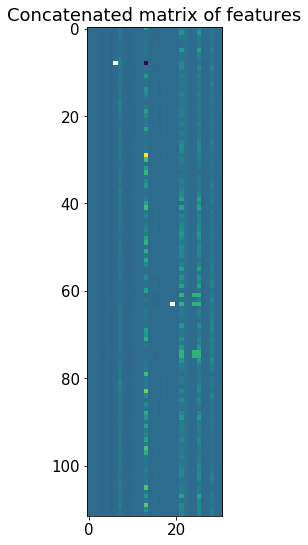

In [54]:
plt.imshow(all_features_matrix)
plt.title('Concatenated matrix of features')

# Save features, names and labels to csv file

In [56]:
# save the data matrix to csv
np.savetxt('ALL_EPHYS_FEATURES_EXP_hipp_GC.csv',all_features_matrix, delimiter=" ")

# save the cell_type names
with open('ALL_EPHYS_EXP_CELL_CELL_NAMES_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(cell_names)
    
# save the patient labels
with open('ALL_EPHYS_EXP_PATIENT_LABELS_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(patient_label)
    
# save the feature names
with open('ALL_EPHYS_EXP_FEATURE_NAMES_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(feature_names)